<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 3: Generative Adversarial Networks
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

In [1]:
name = 'AmirHossein Naghdi'
std_id = '400102169'

**Libraries**

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid
import torch.nn.functional as F
import yaml
import numpy as np

### In this notebook, you will implement the required components from scratch, without code completion. Utilize `torch` to create models and perform optimization. The goal of this assignment is to implement Deep Convolutional Generative Adversarial Networks (DC-GAN) using the MNIST dataset and to explore interpolation in the latent space.

### To get started, please read the DC-GAN paper available at this link: [DC-GAN Paper](https://arxiv.org/abs/1511.06434v2).


### Part 1. Load the MNIST dataset.

In [8]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to [-1, 1]
])

# Load the MNIST dataset
batch_size = 128
dataset = torchvision.datasets.MNIST(
    root='./data',  # Path to store the dataset
    train=True,     # Load training set
    transform=transform,  # Apply transformations
    download=True   # Download if not already available
)

# Create DataLoaders for batching
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Print dataset sizes
print(f"Training Set: {len(dataset)} samples")

Training Set: 60000 samples


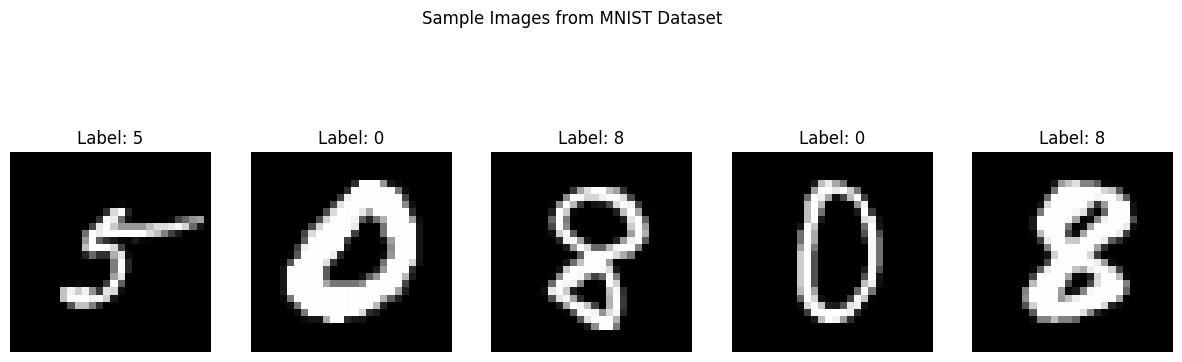

In [9]:
# Visualize some images from the dataset
def show_images(images, labels, title):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    for i, (img, label) in enumerate(zip(images, labels)):
        axs[i].imshow(img.squeeze(), cmap='gray')
        axs[i].set_title(f"Label: {label}")
        axs[i].axis('off')
    plt.suptitle(title)
    plt.show()

# Fetch a batch of images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Display the first 5 images and their labels
show_images(images[:5], labels[:5], title="Sample Images from MNIST Dataset")

### Part 2: Build the Generator and Discriminator models.
Build the models with the architecture guidelines for stable training as described in the paper. It is recommended to use the model parameters presented in `config.yaml`, but you are free to choose any set of parameters you prefer.


#### Generator Model:
The Generator is designed to take in a latent vector (which is typically a random noise vector) and transform it into a generated image, such as a 28x28 pixel image (as is common with datasets like MNIST). The Generator model consists of several layers of transposed convolutions (also known as deconvolutions), which gradually upsample the latent vector into a full-size image. These layers are followed by batch normalization and ReLU activation functions to introduce non-linearity and stabilize training.

- **Latent Vector**: The input to the Generator is a latent vector with a fixed dimension (`latent_dim`), typically 100.
- **Transposed Convolutions**: These layers upsample the input latent vector into an image, with each layer having its own set of parameters like the number of channels, kernel size, stride, padding, and output padding.
- **Final Output**: The final layer produces a 28x28 grayscale image using a `Tanh` activation to map the pixel values to the range [-1, 1].

#### Discriminator Model:
The Discriminator model's role is to distinguish between real and generated images. It takes an image as input and outputs a probability that the image is real (from the training dataset) or fake (generated by the Generator). The Discriminator is made up of several convolutional layers followed by LeakyReLU activations, which help the model handle negative values during training. The output of the Discriminator is a single value between 0 and 1, representing the probability of the image being real.

- **Convolutions**: The Discriminator uses regular convolutions to process the input image. It starts with a single channel (for grayscale images) and progressively increases the number of channels.
- **LeakyReLU**: This activation function allows for small negative values, which helps avoid "dead neurons" during training.
- **Final Layer**: The output layer is a fully connected layer followed by a sigmoid function, which gives a probability indicating whether the image is real or fake.

#### Model Parameters:
Both the Generator and Discriminator use parameters such as the number of channels, kernel sizes, strides, and paddings for each convolutional layer. These parameters are defined in the `config.yaml` file, which contains the architecture configuration for both models.

Here’s a summary of the architecture parameters:

- **Generator**:
  - `latent_dim`: The dimension of the input latent vector.
  - `generator_channels`: The number of channels for each convolutional layer.
  - `generator_kernels`: The kernel sizes for the transposed convolutions.
  - `generator_strides`: The stride values for upsampling.
  - `generator_paddings`: The padding applied to maintain image dimensions.
  - `generator_output_paddings`: Used to control the output size for each layer.

- **Discriminator**:
  - `discriminator_channels`: The number of channels for each convolutional layer.
  - `discriminator_kernels`: The kernel sizes for the convolutions.
  - `discriminator_strides`: The stride values for downsampling.
  - `discriminator_paddings`: Padding applied to the convolutional layers.






In [11]:
config_file_path = '/content/config.yaml'
with open(config_file_path, 'r') as file:
    config_data = yaml.safe_load(file)

# Print the contents of the config file
print(config_data)

{'model_params': {'latent_dim': 100, 'generator_channels': [512, 256, 128], 'generator_kernels': [4, 4, 4, 4], 'generator_strides': [2, 2, 2, 2], 'generator_paddings': [1, 1, 1, 1], 'generator_output_paddings': [1, 1, 0, 0], 'discriminator_channels': [128, 256, 512], 'discriminator_kernels': [4, 4, 4, 4], 'discriminator_strides': [2, 2, 2, 2], 'discriminator_paddings': [1, 1, 1, 1]}}


In [12]:
# Generator class
class Generator(nn.Module):
    def __init__(self, latent_dim, generator_channels, generator_kernels,
                 generator_strides, generator_paddings, generator_output_paddings):
        super(Generator, self).__init__()

        layers = []
        input_channels = latent_dim  # Latent vector has `latent_dim` channels

        # Build generator layers from the config
        for i in range(len(generator_channels)):
            layers.append(nn.ConvTranspose2d(input_channels, generator_channels[i],
                                             kernel_size=generator_kernels[i],
                                             stride=generator_strides[i],
                                             padding=generator_paddings[i],
                                             output_padding=generator_output_paddings[i]))
            layers.append(nn.BatchNorm2d(generator_channels[i]))
            layers.append(nn.ReLU(True))
            input_channels = generator_channels[i]  # Update input channels for next layer

        # Final layer to output 1-channel image (28x28)
        layers.append(nn.ConvTranspose2d(input_channels, 1, kernel_size=4, stride=2, padding=1, output_padding=1))
        layers.append(nn.Tanh())  # Output images in range [-1, 1]

        self.model = nn.Sequential(*layers)

    def forward(self, z):
        return self.model(z)


# Discriminator class
class Discriminator(nn.Module):
    def __init__(self, discriminator_channels, discriminator_kernels,
                 discriminator_strides, discriminator_paddings):
        super(Discriminator, self).__init__()

        layers = []
        input_channels = 1  # MNIST images have 1 channel

        # Build discriminator layers from the config
        for i in range(len(discriminator_channels)):
            layers.append(nn.Conv2d(input_channels, discriminator_channels[i],
                                    kernel_size=discriminator_kernels[i],
                                    stride=discriminator_strides[i],
                                    padding=discriminator_paddings[i]))
            layers.append(nn.LeakyReLU(0.2, inplace=True))  # Use LeakyReLU for the discriminator
            input_channels = discriminator_channels[i]  # Update input channels for next layer

        # Flatten the output and pass through a fully connected layer
        self.model = nn.Sequential(
            *layers,
            nn.Flatten(),  # Flatten the output
            nn.Linear(discriminator_channels[-1] * 3 * 3, 1),  # Adjusted size based on feature map size
            nn.Sigmoid()  # Output a probability for real/fake
        )

    def forward(self, img):
        return self.model(img)

In [13]:
latent_dim = config_data['model_params']['latent_dim']
generator_channels = config_data['model_params']['generator_channels']
generator_kernels = config_data['model_params']['generator_kernels']
generator_strides = config_data['model_params']['generator_strides']
generator_paddings = config_data['model_params']['generator_paddings']
generator_output_paddings = config_data['model_params']['generator_output_paddings']

discriminator_channels = config_data['model_params']['discriminator_channels']
discriminator_kernels = config_data['model_params']['discriminator_kernels']
discriminator_strides = config_data['model_params']['discriminator_strides']
discriminator_paddings = config_data['model_params']['discriminator_paddings']

# Instantiate models
generator = Generator(latent_dim, generator_channels, generator_kernels,
                      generator_strides, generator_paddings, generator_output_paddings)

discriminator = Discriminator(discriminator_channels, discriminator_kernels,
                               discriminator_strides, discriminator_paddings)

print(generator)
print(discriminator)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (10): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Con

### Part 3: Write a function to train the models using the GAN framework.
You can refer to the slides or the original GAN paper for the training schema: [GAN Paper](https://arxiv.org/abs/1406.2661). Additionally, create a function to generate samples from the model. Ensure to plot a grid of generated samples every n'th epoch.


1. **Loss Function**:  
   The `adversarial_loss` uses Binary Cross-Entropy (BCE) to measure how well the discriminator can classify real vs. fake images. This loss is also used for training the generator to make more realistic images.

2. **Optimizers**:  
   Two separate Adam optimizers are used:
   - One for the generator (`optimizer_G`).
   - One for the discriminator (`optimizer_D`).

3. **Training Loop**:  
   The training process runs for a set number of epochs, with each epoch looping through batches of images from the dataset:
   - **Train the Generator**: Generate fake images from random noise. The goal is to "fool" the discriminator into classifying these fake images as real.  
   - **Train the Discriminator**: Teach it to classify real images as real and fake images as fake.  
   - Both networks are updated in each step to progressively improve.

4. **Sample Generation**:  
   At regular intervals (`sample_interval`), the generator is used to create and display a grid of fake images. This helps visualize the generator's progress over time.



In [14]:
# Loss function for GANs (Binary Cross-Entropy)
adversarial_loss = nn.BCELoss()

# Training function
def train_gan(generator, discriminator, train_loader, latent_dim, num_epochs, device, sample_interval):
    # Move models to the correct device
    generator.to(device)
    discriminator.to(device)
    adversarial_loss.to(device)

    # Optimizers for Generator and Discriminator
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    # Training loop
    for epoch in range(num_epochs):
        for i, (imgs, _) in enumerate(train_loader):
            batch_size = imgs.size(0)

            # Create labels for real and fake images
            valid = torch.ones(batch_size, 1, device=device)  # Real labels
            fake = torch.zeros(batch_size, 1, device=device)  # Fake labels

            # Move real images to the correct device
            real_imgs = imgs.to(device)

            # ---------------------
            # Train Generator
            # ---------------------
            optimizer_G.zero_grad()

            # Sample random noise as input for the generator
            z = torch.randn(batch_size, latent_dim, 1, 1, device=device)

            # Generate fake images
            gen_imgs = generator(z)

            # Calculate the generator loss (maximize the likelihood of discriminator output being real)
            g_loss = adversarial_loss(discriminator(gen_imgs), valid)

            g_loss.backward()  # Backpropagate and update generator
            optimizer_G.step()

            # ---------------------
            # Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()

            # Calculate the discriminator loss on real images
            real_loss = adversarial_loss(discriminator(real_imgs), valid)

            # Calculate the discriminator loss on fake images (detach generator output to avoid backprop through it)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)

            # Total discriminator loss
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()  # Backpropagate and update discriminator
            optimizer_D.step()

            # Print the training progress every 50 batches
            if i % 50 == 0:
                print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {i}/{len(train_loader)}] "
                      f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

        # Save and display generated samples every `sample_interval` epochs
        if (epoch+1) % sample_interval == 0:
            generate_samples(generator, latent_dim, device, epoch)

# Function to generate and plot samples
def generate_samples(generator, latent_dim, device, epoch, num_samples=25):
    generator.eval()  # Set the generator to evaluation mode
    z = torch.randn(num_samples, latent_dim, 1, 1, device=device)  # Generate random noise
    gen_imgs = generator(z).detach().cpu()  # Generate images from the noise

    # Rescale images to [0, 1]
    gen_imgs = (gen_imgs + 1) / 2  # Scale to [0, 1] since generated images are in [-1, 1]

    # Create a grid of images
    grid = make_grid(gen_imgs, nrow=5, normalize=True)

    # Plot the generated images
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).numpy())  # Convert tensor to numpy array
    plt.title(f"Generated Samples at Epoch {epoch}")
    plt.axis('off')  # Hide axes
    plt.show()


[Epoch 1/50] [Batch 0/469] [D loss: 0.6951] [G loss: 0.6900]
[Epoch 1/50] [Batch 50/469] [D loss: 0.0968] [G loss: 1.7488]
[Epoch 1/50] [Batch 100/469] [D loss: 0.3321] [G loss: 1.7285]
[Epoch 1/50] [Batch 150/469] [D loss: 0.4702] [G loss: 1.3594]
[Epoch 1/50] [Batch 200/469] [D loss: 0.9898] [G loss: 2.8870]
[Epoch 1/50] [Batch 250/469] [D loss: 0.9830] [G loss: 5.7670]
[Epoch 1/50] [Batch 300/469] [D loss: 0.2936] [G loss: 2.4499]
[Epoch 1/50] [Batch 350/469] [D loss: 0.3571] [G loss: 1.7369]
[Epoch 1/50] [Batch 400/469] [D loss: 0.3161] [G loss: 1.4636]
[Epoch 1/50] [Batch 450/469] [D loss: 0.1694] [G loss: 2.2108]
[Epoch 2/50] [Batch 0/469] [D loss: 0.1810] [G loss: 1.7563]
[Epoch 2/50] [Batch 50/469] [D loss: 0.4144] [G loss: 1.2849]
[Epoch 2/50] [Batch 100/469] [D loss: 0.3562] [G loss: 1.8574]
[Epoch 2/50] [Batch 150/469] [D loss: 0.3619] [G loss: 1.5260]
[Epoch 2/50] [Batch 200/469] [D loss: 0.5541] [G loss: 2.5102]
[Epoch 2/50] [Batch 250/469] [D loss: 0.4453] [G loss: 3.4814

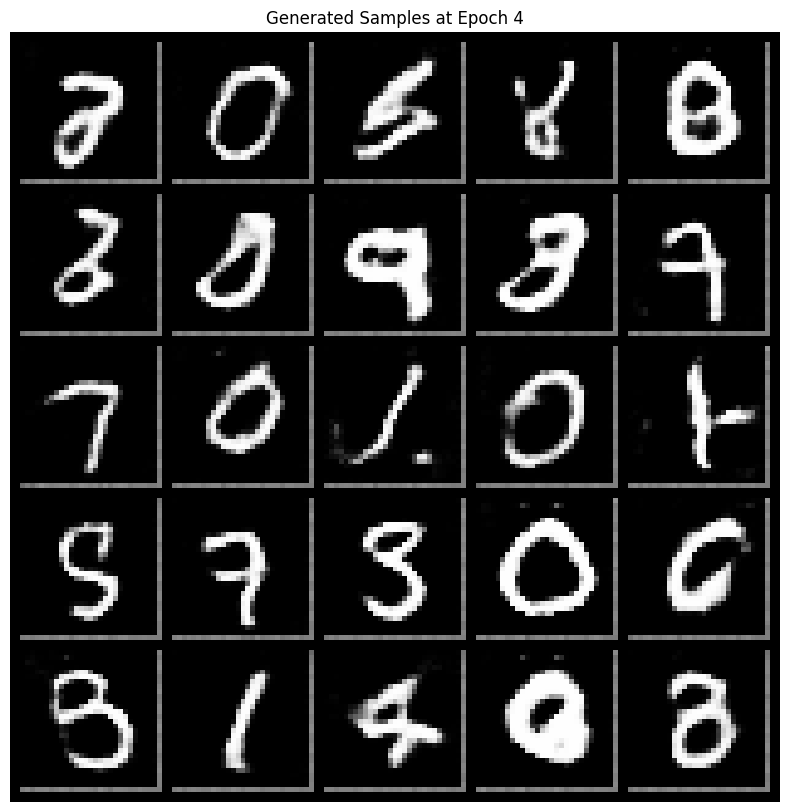

[Epoch 6/50] [Batch 0/469] [D loss: 0.5276] [G loss: 0.9286]
[Epoch 6/50] [Batch 50/469] [D loss: 0.6973] [G loss: 0.7778]
[Epoch 6/50] [Batch 100/469] [D loss: 0.6850] [G loss: 1.0844]
[Epoch 6/50] [Batch 150/469] [D loss: 0.5064] [G loss: 1.2206]
[Epoch 6/50] [Batch 200/469] [D loss: 0.5744] [G loss: 1.2362]
[Epoch 6/50] [Batch 250/469] [D loss: 0.6290] [G loss: 0.9854]
[Epoch 6/50] [Batch 300/469] [D loss: 0.6116] [G loss: 1.0890]
[Epoch 6/50] [Batch 350/469] [D loss: 0.5713] [G loss: 1.4280]
[Epoch 6/50] [Batch 400/469] [D loss: 0.4915] [G loss: 1.1647]
[Epoch 6/50] [Batch 450/469] [D loss: 0.5430] [G loss: 1.0328]
[Epoch 7/50] [Batch 0/469] [D loss: 0.4955] [G loss: 0.9573]
[Epoch 7/50] [Batch 50/469] [D loss: 0.4943] [G loss: 1.1026]
[Epoch 7/50] [Batch 100/469] [D loss: 0.6105] [G loss: 1.4210]
[Epoch 7/50] [Batch 150/469] [D loss: 0.6647] [G loss: 0.7900]
[Epoch 7/50] [Batch 200/469] [D loss: 0.6477] [G loss: 1.0333]
[Epoch 7/50] [Batch 250/469] [D loss: 0.6930] [G loss: 1.4568

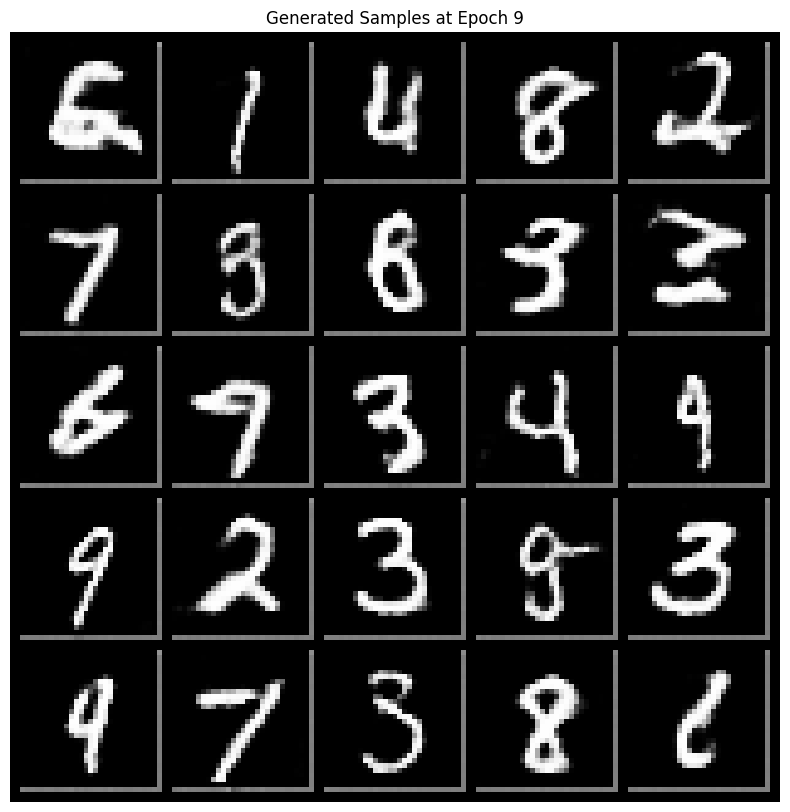

[Epoch 11/50] [Batch 0/469] [D loss: 0.6181] [G loss: 1.0701]
[Epoch 11/50] [Batch 50/469] [D loss: 0.5555] [G loss: 0.9482]
[Epoch 11/50] [Batch 100/469] [D loss: 0.6170] [G loss: 1.0467]
[Epoch 11/50] [Batch 150/469] [D loss: 0.6450] [G loss: 0.7658]
[Epoch 11/50] [Batch 200/469] [D loss: 0.6125] [G loss: 1.0819]
[Epoch 11/50] [Batch 250/469] [D loss: 0.6663] [G loss: 0.6209]
[Epoch 11/50] [Batch 300/469] [D loss: 0.5604] [G loss: 1.0383]
[Epoch 11/50] [Batch 350/469] [D loss: 0.6504] [G loss: 0.6700]
[Epoch 11/50] [Batch 400/469] [D loss: 0.6756] [G loss: 0.7019]
[Epoch 11/50] [Batch 450/469] [D loss: 0.6260] [G loss: 0.8819]
[Epoch 12/50] [Batch 0/469] [D loss: 0.6084] [G loss: 0.9969]
[Epoch 12/50] [Batch 50/469] [D loss: 0.6105] [G loss: 0.6828]
[Epoch 12/50] [Batch 100/469] [D loss: 0.5763] [G loss: 0.8330]
[Epoch 12/50] [Batch 150/469] [D loss: 0.5283] [G loss: 1.0115]
[Epoch 12/50] [Batch 200/469] [D loss: 0.6001] [G loss: 1.1671]
[Epoch 12/50] [Batch 250/469] [D loss: 0.6434]

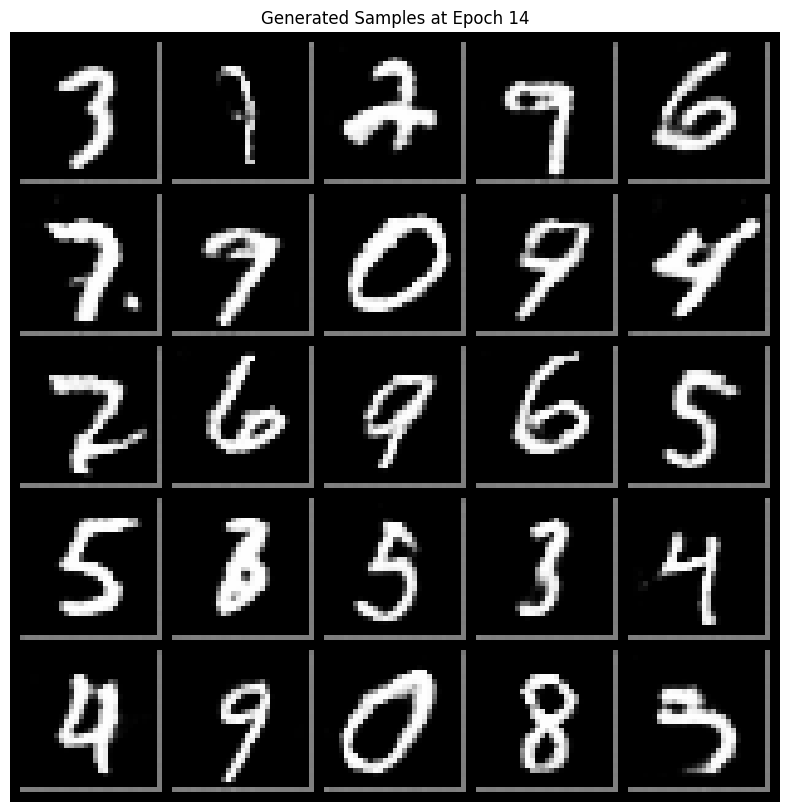

[Epoch 16/50] [Batch 0/469] [D loss: 0.5993] [G loss: 0.9182]
[Epoch 16/50] [Batch 50/469] [D loss: 0.5775] [G loss: 0.9791]
[Epoch 16/50] [Batch 100/469] [D loss: 0.6587] [G loss: 1.2796]
[Epoch 16/50] [Batch 150/469] [D loss: 0.5954] [G loss: 0.8521]
[Epoch 16/50] [Batch 200/469] [D loss: 0.6362] [G loss: 0.8661]
[Epoch 16/50] [Batch 250/469] [D loss: 0.5821] [G loss: 1.1066]
[Epoch 16/50] [Batch 300/469] [D loss: 0.6135] [G loss: 1.2280]
[Epoch 16/50] [Batch 350/469] [D loss: 0.6272] [G loss: 0.7343]
[Epoch 16/50] [Batch 400/469] [D loss: 0.5632] [G loss: 0.9963]
[Epoch 16/50] [Batch 450/469] [D loss: 0.6113] [G loss: 0.8432]
[Epoch 17/50] [Batch 0/469] [D loss: 0.6067] [G loss: 0.7794]
[Epoch 17/50] [Batch 50/469] [D loss: 0.6368] [G loss: 0.7045]
[Epoch 17/50] [Batch 100/469] [D loss: 0.5201] [G loss: 1.2773]
[Epoch 17/50] [Batch 150/469] [D loss: 0.6208] [G loss: 0.9931]
[Epoch 17/50] [Batch 200/469] [D loss: 0.5863] [G loss: 1.0594]
[Epoch 17/50] [Batch 250/469] [D loss: 0.6063]

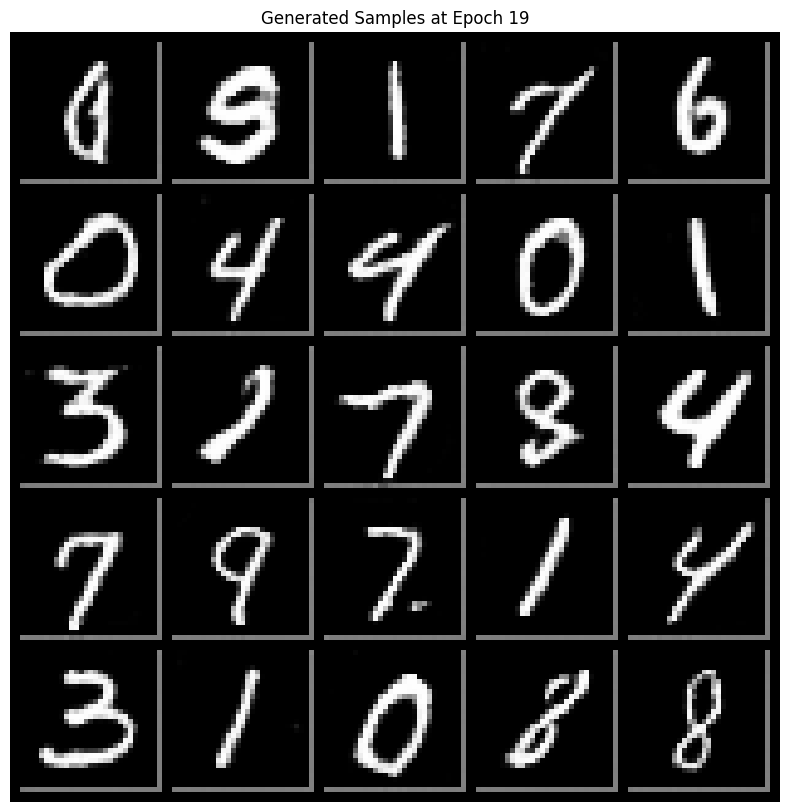

[Epoch 21/50] [Batch 0/469] [D loss: 0.6333] [G loss: 0.9155]
[Epoch 21/50] [Batch 50/469] [D loss: 0.6458] [G loss: 0.6478]
[Epoch 21/50] [Batch 100/469] [D loss: 0.5928] [G loss: 0.7956]
[Epoch 21/50] [Batch 150/469] [D loss: 0.5880] [G loss: 0.9787]
[Epoch 21/50] [Batch 200/469] [D loss: 0.5809] [G loss: 0.8927]
[Epoch 21/50] [Batch 250/469] [D loss: 0.6067] [G loss: 0.8534]
[Epoch 21/50] [Batch 300/469] [D loss: 0.6007] [G loss: 0.9098]
[Epoch 21/50] [Batch 350/469] [D loss: 0.6010] [G loss: 0.9801]
[Epoch 21/50] [Batch 400/469] [D loss: 0.6238] [G loss: 1.1750]
[Epoch 21/50] [Batch 450/469] [D loss: 0.5886] [G loss: 1.1523]
[Epoch 22/50] [Batch 0/469] [D loss: 0.5846] [G loss: 0.8540]
[Epoch 22/50] [Batch 50/469] [D loss: 0.5867] [G loss: 0.9693]
[Epoch 22/50] [Batch 100/469] [D loss: 0.5939] [G loss: 1.0558]
[Epoch 22/50] [Batch 150/469] [D loss: 0.6115] [G loss: 0.9395]
[Epoch 22/50] [Batch 200/469] [D loss: 0.6055] [G loss: 0.8740]
[Epoch 22/50] [Batch 250/469] [D loss: 0.6678]

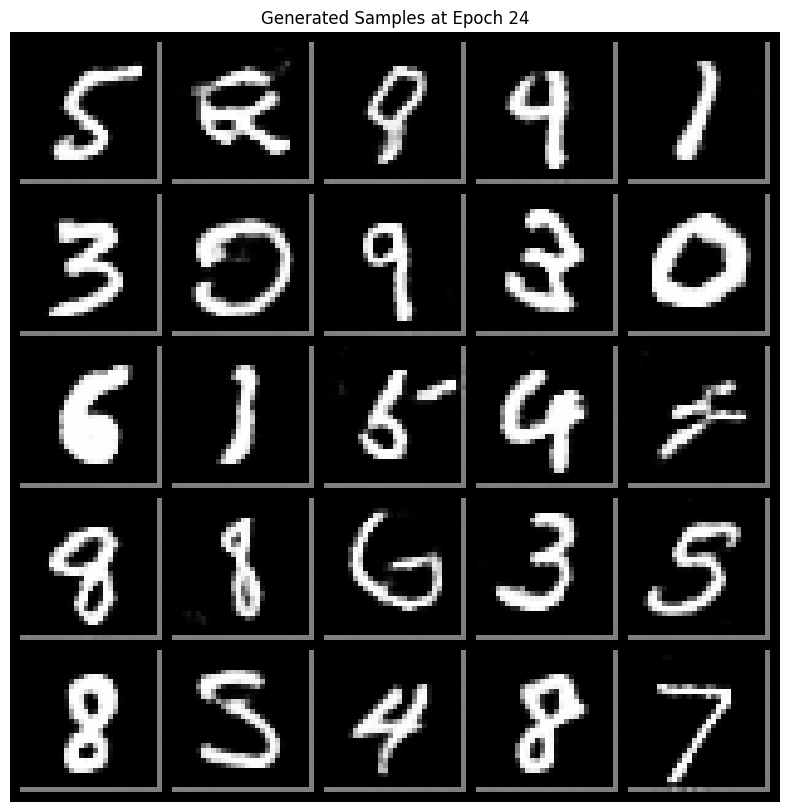

[Epoch 26/50] [Batch 0/469] [D loss: 0.5718] [G loss: 1.1647]
[Epoch 26/50] [Batch 50/469] [D loss: 0.6510] [G loss: 1.3129]
[Epoch 26/50] [Batch 100/469] [D loss: 0.5942] [G loss: 1.0798]
[Epoch 26/50] [Batch 150/469] [D loss: 0.6336] [G loss: 1.2635]
[Epoch 26/50] [Batch 200/469] [D loss: 0.5395] [G loss: 0.9860]
[Epoch 26/50] [Batch 250/469] [D loss: 0.6097] [G loss: 1.0189]
[Epoch 26/50] [Batch 300/469] [D loss: 0.6287] [G loss: 1.2629]
[Epoch 26/50] [Batch 350/469] [D loss: 0.6003] [G loss: 0.8914]
[Epoch 26/50] [Batch 400/469] [D loss: 0.6150] [G loss: 0.9646]
[Epoch 26/50] [Batch 450/469] [D loss: 0.5988] [G loss: 1.1362]
[Epoch 27/50] [Batch 0/469] [D loss: 0.6481] [G loss: 0.6292]
[Epoch 27/50] [Batch 50/469] [D loss: 0.6237] [G loss: 1.0744]
[Epoch 27/50] [Batch 100/469] [D loss: 0.5349] [G loss: 0.9540]
[Epoch 27/50] [Batch 150/469] [D loss: 0.5742] [G loss: 1.0780]
[Epoch 27/50] [Batch 200/469] [D loss: 0.6343] [G loss: 1.4709]
[Epoch 27/50] [Batch 250/469] [D loss: 0.5955]

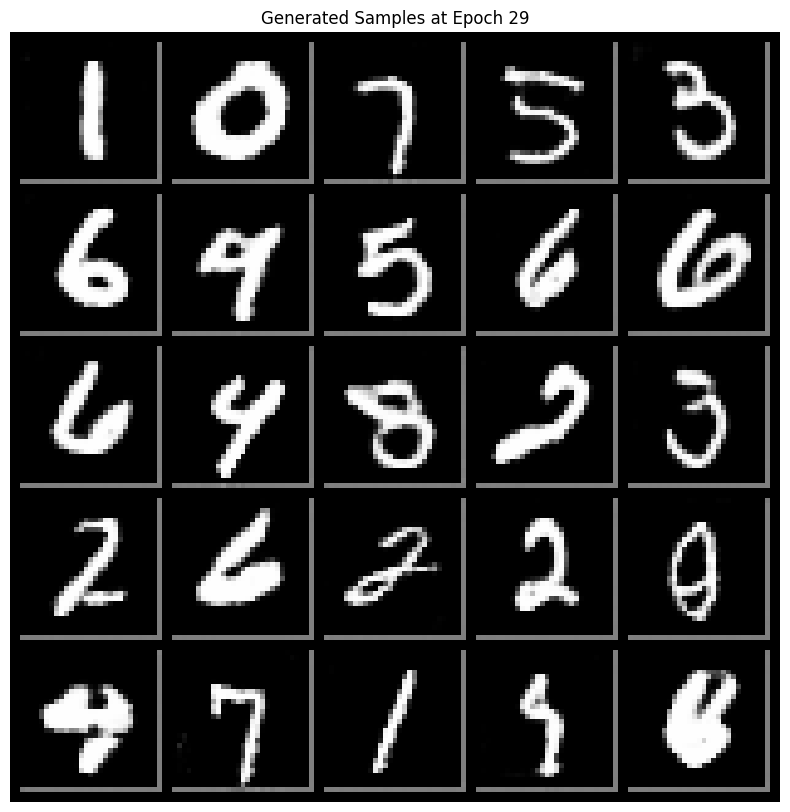

[Epoch 31/50] [Batch 0/469] [D loss: 0.6145] [G loss: 1.1552]
[Epoch 31/50] [Batch 50/469] [D loss: 0.5809] [G loss: 0.9626]
[Epoch 31/50] [Batch 100/469] [D loss: 0.6007] [G loss: 0.6879]
[Epoch 31/50] [Batch 150/469] [D loss: 0.6713] [G loss: 0.6799]
[Epoch 31/50] [Batch 200/469] [D loss: 0.5717] [G loss: 1.1147]
[Epoch 31/50] [Batch 250/469] [D loss: 0.5601] [G loss: 1.2793]
[Epoch 31/50] [Batch 300/469] [D loss: 0.5904] [G loss: 0.9272]
[Epoch 31/50] [Batch 350/469] [D loss: 0.5594] [G loss: 1.1758]
[Epoch 31/50] [Batch 400/469] [D loss: 0.5585] [G loss: 1.0560]
[Epoch 31/50] [Batch 450/469] [D loss: 0.6002] [G loss: 1.2567]
[Epoch 32/50] [Batch 0/469] [D loss: 0.5762] [G loss: 1.1794]
[Epoch 32/50] [Batch 50/469] [D loss: 0.6132] [G loss: 1.3175]
[Epoch 32/50] [Batch 100/469] [D loss: 0.6412] [G loss: 0.6989]
[Epoch 32/50] [Batch 150/469] [D loss: 0.5494] [G loss: 0.9392]
[Epoch 32/50] [Batch 200/469] [D loss: 0.5677] [G loss: 0.9066]
[Epoch 32/50] [Batch 250/469] [D loss: 0.6225]

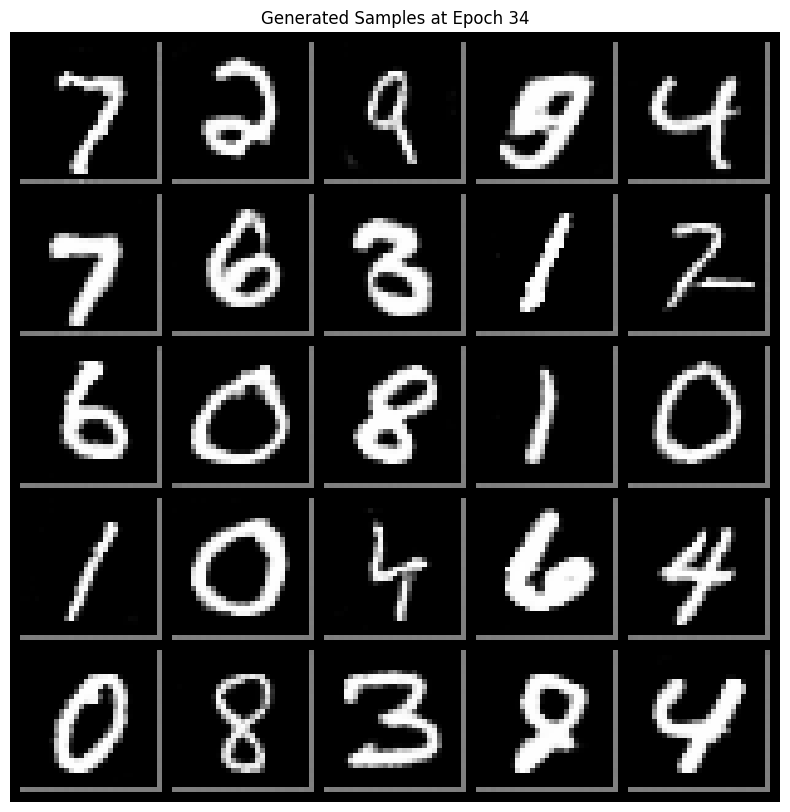

[Epoch 36/50] [Batch 0/469] [D loss: 0.5732] [G loss: 0.8960]
[Epoch 36/50] [Batch 50/469] [D loss: 0.6196] [G loss: 0.8121]
[Epoch 36/50] [Batch 100/469] [D loss: 0.5703] [G loss: 1.0190]
[Epoch 36/50] [Batch 150/469] [D loss: 0.5509] [G loss: 1.0151]
[Epoch 36/50] [Batch 200/469] [D loss: 0.5749] [G loss: 1.0846]
[Epoch 36/50] [Batch 250/469] [D loss: 0.5637] [G loss: 0.9750]
[Epoch 36/50] [Batch 300/469] [D loss: 0.5418] [G loss: 0.9041]
[Epoch 36/50] [Batch 350/469] [D loss: 0.5916] [G loss: 1.1903]
[Epoch 36/50] [Batch 400/469] [D loss: 0.5835] [G loss: 0.9208]
[Epoch 36/50] [Batch 450/469] [D loss: 0.6092] [G loss: 0.8008]
[Epoch 37/50] [Batch 0/469] [D loss: 0.5536] [G loss: 0.7728]
[Epoch 37/50] [Batch 50/469] [D loss: 0.5658] [G loss: 1.1572]
[Epoch 37/50] [Batch 100/469] [D loss: 0.5347] [G loss: 0.9658]
[Epoch 37/50] [Batch 150/469] [D loss: 0.5505] [G loss: 0.8833]
[Epoch 37/50] [Batch 200/469] [D loss: 0.5468] [G loss: 0.9341]
[Epoch 37/50] [Batch 250/469] [D loss: 0.6868]

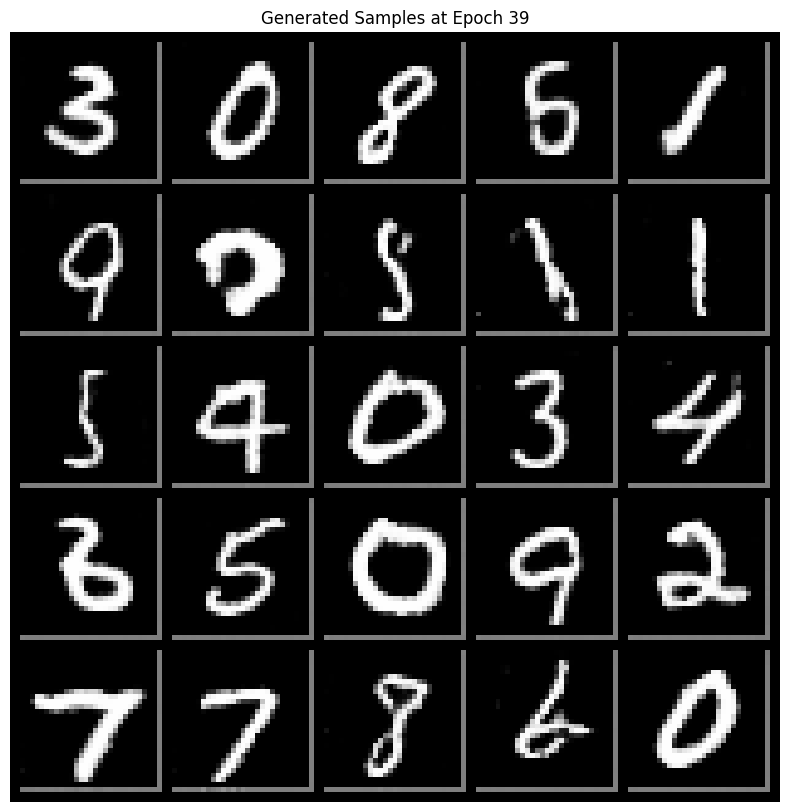

[Epoch 41/50] [Batch 0/469] [D loss: 0.5728] [G loss: 0.9128]
[Epoch 41/50] [Batch 50/469] [D loss: 0.5459] [G loss: 1.2365]
[Epoch 41/50] [Batch 100/469] [D loss: 0.5563] [G loss: 0.9893]
[Epoch 41/50] [Batch 150/469] [D loss: 0.5555] [G loss: 0.8312]
[Epoch 41/50] [Batch 200/469] [D loss: 0.5589] [G loss: 0.8631]
[Epoch 41/50] [Batch 250/469] [D loss: 0.6115] [G loss: 0.6786]
[Epoch 41/50] [Batch 300/469] [D loss: 0.5736] [G loss: 0.8704]
[Epoch 41/50] [Batch 350/469] [D loss: 0.5841] [G loss: 1.3739]
[Epoch 41/50] [Batch 400/469] [D loss: 0.4918] [G loss: 1.0923]
[Epoch 41/50] [Batch 450/469] [D loss: 0.5391] [G loss: 1.3143]
[Epoch 42/50] [Batch 0/469] [D loss: 0.5772] [G loss: 0.9401]
[Epoch 42/50] [Batch 50/469] [D loss: 0.5453] [G loss: 0.9105]
[Epoch 42/50] [Batch 100/469] [D loss: 0.5166] [G loss: 1.3576]
[Epoch 42/50] [Batch 150/469] [D loss: 0.5021] [G loss: 1.0352]
[Epoch 42/50] [Batch 200/469] [D loss: 0.5504] [G loss: 0.8335]
[Epoch 42/50] [Batch 250/469] [D loss: 0.5621]

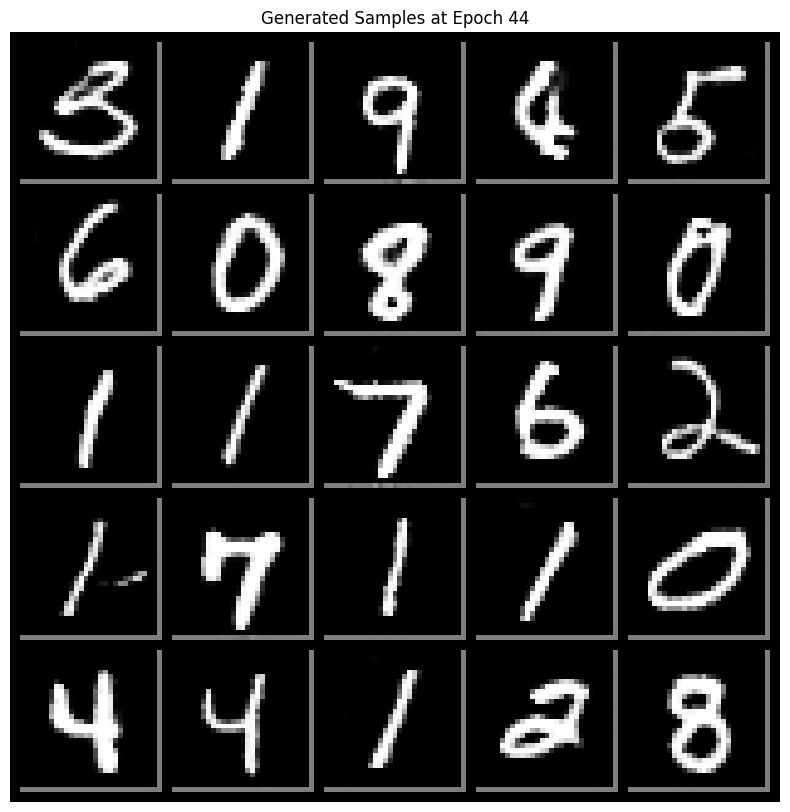

[Epoch 46/50] [Batch 0/469] [D loss: 0.5700] [G loss: 0.8640]
[Epoch 46/50] [Batch 50/469] [D loss: 0.5245] [G loss: 1.0531]
[Epoch 46/50] [Batch 100/469] [D loss: 0.4896] [G loss: 0.9932]
[Epoch 46/50] [Batch 150/469] [D loss: 0.6348] [G loss: 1.8488]
[Epoch 46/50] [Batch 200/469] [D loss: 0.5524] [G loss: 1.0159]
[Epoch 46/50] [Batch 250/469] [D loss: 0.5632] [G loss: 1.2300]
[Epoch 46/50] [Batch 300/469] [D loss: 0.5722] [G loss: 0.8181]
[Epoch 46/50] [Batch 350/469] [D loss: 0.6964] [G loss: 0.4971]
[Epoch 46/50] [Batch 400/469] [D loss: 0.5928] [G loss: 1.8185]
[Epoch 46/50] [Batch 450/469] [D loss: 0.5810] [G loss: 1.3688]
[Epoch 47/50] [Batch 0/469] [D loss: 0.5309] [G loss: 1.4113]
[Epoch 47/50] [Batch 50/469] [D loss: 0.5106] [G loss: 1.5160]
[Epoch 47/50] [Batch 100/469] [D loss: 0.5691] [G loss: 1.2475]
[Epoch 47/50] [Batch 150/469] [D loss: 0.6343] [G loss: 0.5589]
[Epoch 47/50] [Batch 200/469] [D loss: 0.5293] [G loss: 1.3580]
[Epoch 47/50] [Batch 250/469] [D loss: 0.5805]

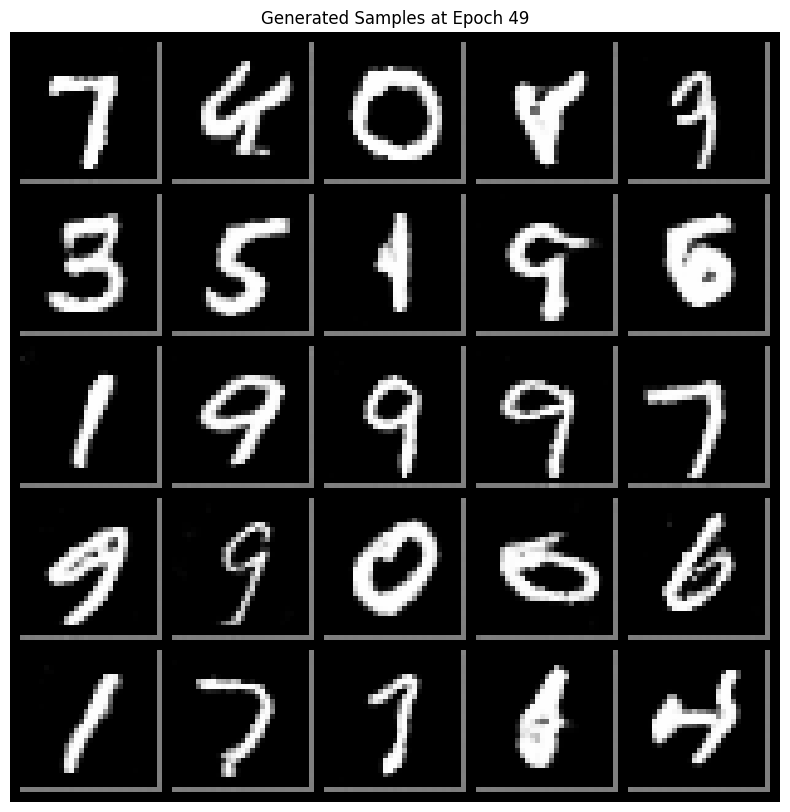

In [15]:
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training parameters
num_epochs = 50
latent_dim = config_data['model_params']['latent_dim']
sample_interval = 5

# Assume train_loader is your DataLoader for the dataset (e.g., MNIST)
train_gan(generator, discriminator, train_loader, latent_dim, num_epochs, device, sample_interval)


**Save Model**

In [19]:
# Save the generator state and configuration
save_path = "generator.pth"

# Save both the model weights and configuration for reproducibility
torch.save({
    'model_state_dict': generator.state_dict(),
    'latent_dim': latent_dim,
    'generator_channels': generator_channels,
    'generator_kernels': generator_kernels,
    'generator_strides': generator_strides,
    'generator_paddings': generator_paddings,
    'generator_output_paddings': generator_output_paddings
}, save_path)

print(f"Generator saved to {save_path}")

Generator saved to generator.pth


**Load Model**

In [ ]:
# Load the saved generator state
checkpoint = torch.load("generator.pth")

# Retrieve configuration and initialize the generator
latent_dim = checkpoint['latent_dim']
generator_channels = checkpoint['generator_channels']
generator_kernels = checkpoint['generator_kernels']
generator_strides = checkpoint['generator_strides']
generator_paddings = checkpoint['generator_paddings']
generator_output_paddings = checkpoint['generator_output_paddings']

# Recreate the Generator
generator = Generator(latent_dim, generator_channels, generator_kernels,
                      generator_strides, generator_paddings, generator_output_paddings)

# Load the model weights
generator.load_state_dict(checkpoint['model_state_dict'])

# Ensure the model is in evaluation mode (for inference)
generator.eval()

print("Generator reloaded successfully")


### Part 4: Plot a grid of 100 generated samples.

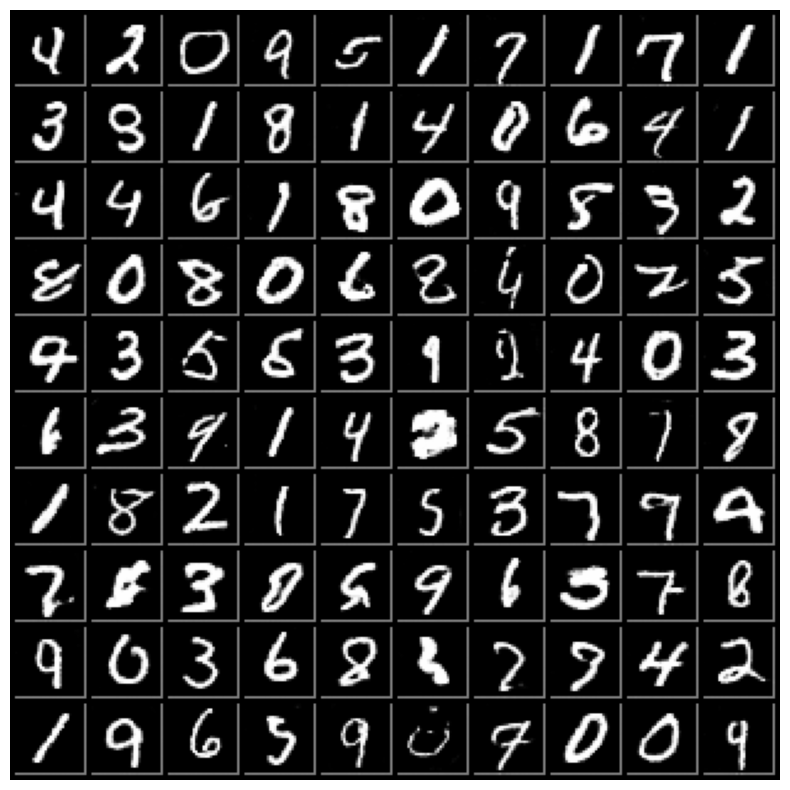

In [16]:
def plot_generated_images(generator, latent_dim, device=device, num_images=100, grid_size=(10, 10)):
    # Set the generator to evaluation mode
    generator.eval()

    # Generate random latent vectors (z)
    z = torch.randn(num_images, latent_dim, 1, 1, device=device)  # Latent vectors for 100 images

    # Generate fake images from the latent vectors
    with torch.no_grad():
        fake_images = generator(z)  # Output shape will be (num_images, 1, 28, 28)

    # Normalize the images to [0, 1] range for plotting
    fake_images = (fake_images + 1) / 2  # Tanh outputs values between [-1, 1], we want [0, 1]

    # Create a grid of images (e.g., 10x10 grid)
    grid = torchvision.utils.make_grid(fake_images, nrow=grid_size[0], normalize=False)

    # Plot the images
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap="gray")  # Permute dimensions for plotting
    plt.axis('off')
    plt.show()

plot_generated_images(generator, latent_dim=100, device=device, num_images=100, grid_size=(10, 10))


### Part 5: GAN Inversion
In this part, we aim to find the latent vectors corresponding to the samples in the dataset. First, select a random sample from the real dataset and a random latent vector. Freeze the generator and feed the random latent vector into the Generator. Next, define an MSE or MAE loss between the generated sample and the real sample, and optimize the random latent vector to discover the latent vector that generates the selected real sample.


1. **Random Initialization**:
   - A latent vector \( z \) is randomly initialized from a normal distribution. This is the starting point of the optimization process.

2. **Freeze the Generator**:
   - The generator is set to evaluation mode (`generator.eval()`), ensuring its parameters remain unchanged during the process. Only the latent vector \( z \) will be optimized.

3. **Loss Function**:
   - The **Mean Squared Error (MSE)** is used to compare the real image and the generated image. This loss quantifies how close the generated image is to the real image.

4. **Optimization**:
   - The latent vector \( z \) is updated iteratively to minimize the MSE loss. The generator produces new images from \( z \) during each optimization step, progressively improving the resemblance to the real image.

5. **Generated Image Matching**:
   - After a specified number of optimization steps (`num_steps`), the process outputs:
     - The optimized latent vector \( z \).
     - The generated image corresponding to \( z \), which closely matches the real image.


<ipython-input-23-7ce7a7900f9e>:25: UserWarning: Using a target size (torch.Size([1, 28, 28])) that is different to the input size (torch.Size([1, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(generated_image_resized, real_image)


Step [0/200], Loss: 0.6326460838317871
Step [100/200], Loss: 0.11282968521118164
Step [0/200], Loss: 0.6610119938850403
Step [100/200], Loss: 0.24013951420783997
Step [0/200], Loss: 0.5198597311973572
Step [100/200], Loss: 0.09161855280399323
Step [0/200], Loss: 0.658555805683136
Step [100/200], Loss: 0.22427210211753845
Step [0/200], Loss: 0.5979699492454529
Step [100/200], Loss: 0.40397021174430847
Step [0/200], Loss: 0.4998531639575958
Step [100/200], Loss: 0.3794471025466919
Step [0/200], Loss: 0.3768068253993988
Step [100/200], Loss: 0.08330924808979034
Step [0/200], Loss: 0.6054581999778748
Step [100/200], Loss: 0.34014108777046204
Step [0/200], Loss: 0.4797031283378601
Step [100/200], Loss: 0.3674062192440033
Step [0/200], Loss: 0.6102786660194397
Step [100/200], Loss: 0.3371341824531555


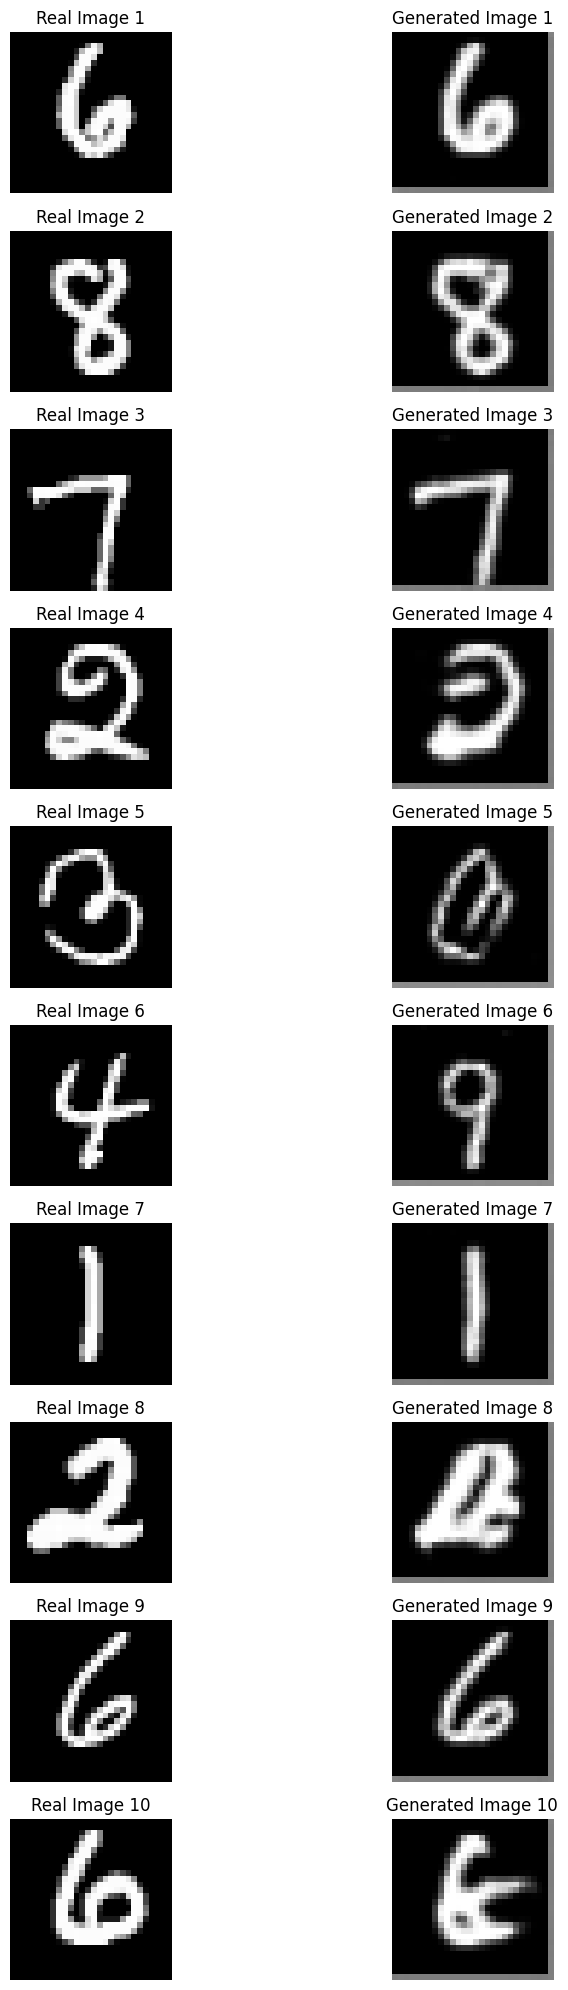

In [ ]:
def invert_to_latent_vector(generator, real_image, latent_dim, device, num_steps=200, lr=0.01):
    # Set generator to evaluation mode (not trainable)
    generator.eval()

    # Initialize the latent vector (z) as a random tensor
    z = torch.randn(1, latent_dim, 1, 1, device=device, requires_grad=True)

    # Set the optimizer for the latent vector (z)
    optimizer = torch.optim.Adam([z], lr=lr, betas=(0.5, 0.999))

    # Normalize the real image to the range [-1, 1]
    if isinstance(real_image, np.ndarray):
        real_image = torch.tensor(real_image, dtype=torch.float32)

    real_image = real_image.to(device)

    for step in range(num_steps):
        # Generate an image from the current latent vector
        generated_image = generator(z)

        # Resize the generated image to match the real image dimensions
        generated_image_resized = F.interpolate(generated_image, size=(28, 28), mode='bilinear', align_corners=False)

        # Calculate the MSE loss between the resized generated image and the real image
        loss = F.mse_loss(generated_image_resized, real_image)

        # Optimize the latent vector (z)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print the loss for monitoring
        if step % 100 == 0:
            print(f"Step [{step}/{num_steps}], Loss: {loss.item()}")

    # After optimization, return the latent vector and the resized generated image
    return z, generated_image_resized


def plot_latent_inversion(real_images, generated_images, n):

    plt.figure(figsize=(10, 2 * n))

    for i in range(n):
        # Plot real image
        plt.subplot(n, 2, 2 * i + 1)
        plt.imshow(real_images[i].cpu().detach().squeeze(), cmap='gray')
        plt.title(f"Real Image {i+1}")
        plt.axis('off')

        # Plot generated image
        plt.subplot(n, 2, 2 * i + 2)
        plt.imshow(generated_images[i].cpu().detach().squeeze(), cmap='gray')
        plt.title(f"Generated Image {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

n = 10  # Number of images to process and plot
real_images = [next(iter(train_loader))[0][i] for i in range(n)]

# Run GAN inversion for each real image
generated_images = []
for real_image in real_images:
    z, generated_image = invert_to_latent_vector(generator, real_image, latent_dim=200, device=device)
    generated_images.append(generated_image)

# Plot the real images and their corresponding generated images
plot_latent_inversion(real_images, generated_images, n)


### Part 6: Interpolating the Latent Space
In this part, you will interpolate the latent space using a 10 by 10 grid. Start with 4 initial points representing the corners of the square, and then perform linear or spherical interpolation between the latent vectors of these 4 images to fill the circumference of the square.
Next, fill in the rest of the square by interpolating between the latent vectors along the circumference.

If $G$ is the generator, and $z_1$ and $z_2$ are two latent vectors of two images, let $w$ be a parameter that varies between $0$ and $1$. The linearly interpolated sample is generated as:

\begin{equation}
G(w \cdot z_1 + (1 - w) \cdot z_2)\
\end{equation}

Try to select the 4 starting images from those that exhibit distinct features. For example, the two top right corners could be the same digit but one with a thick stroke and the other with a thin stroke, while the other two points should be from a different digit but with varying stroke styles.

<ipython-input-23-7ce7a7900f9e>:25: UserWarning: Using a target size (torch.Size([1, 28, 28])) that is different to the input size (torch.Size([1, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(generated_image_resized, real_image)


Step [0/200], Loss: 0.5551307797431946
Step [100/200], Loss: 0.09602658450603485
Step [0/200], Loss: 0.732018232345581
Step [100/200], Loss: 0.40155544877052307
Step [0/200], Loss: 0.4332532286643982
Step [100/200], Loss: 0.3109824061393738
Step [0/200], Loss: 0.1992696225643158
Step [100/200], Loss: 0.08349969983100891


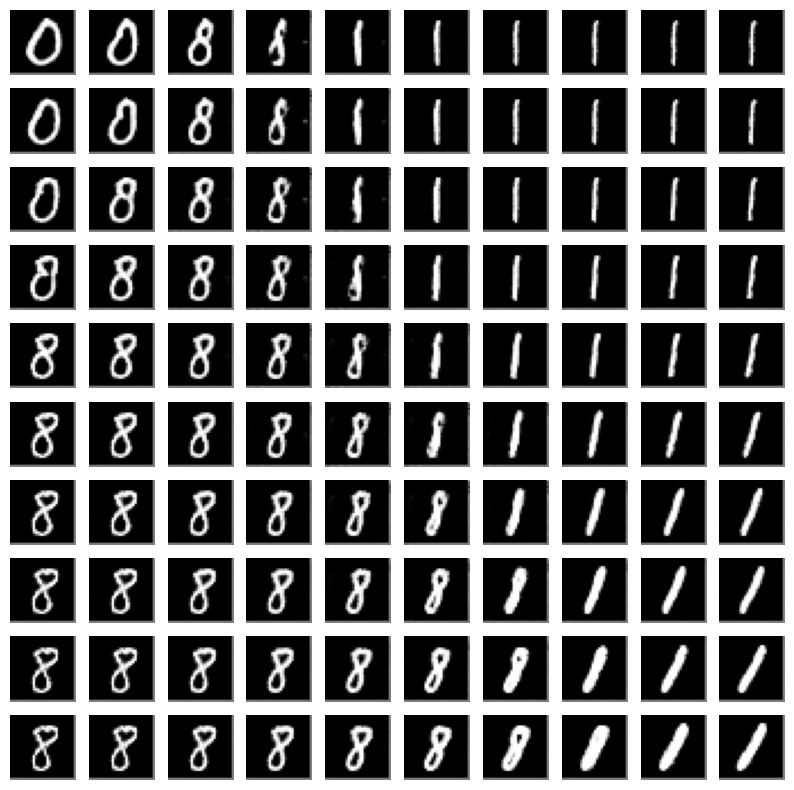

In [24]:
def interpolate_latent_space(generator, latent_vectors, grid_size=10, device=device):
    # Create a grid of latent vectors by interpolating between the four corner vectors
    z1, z2, z3, z4 = latent_vectors

    # Create a 10x10 grid for interpolation
    grid = np.zeros((grid_size, grid_size, 100, 1, 1))  # shape will be (10, 10, latent_dim, 1, 1)

    for i in range(grid_size):
        for j in range(grid_size):
            # Interpolation weights between z1-z2, z2-z4, z4-z3, z3-z1
            w1 = i / (grid_size - 1)  # Weight for the interpolation between z1 and z2
            w2 = j / (grid_size - 1)  # Weight for the interpolation between z2 and z4

            # Interpolate between z1, z2, z3, z4 along the sides of the square
            latent_vector = (1 - w1) * (1 - w2) * z1 + w1 * (1 - w2) * z2 + w1 * w2 * z4 + (1 - w1) * w2 * z3
            grid[i, j] = latent_vector.cpu().detach().numpy()

    # Generate the images using the interpolated latent vectors
    generated_images = []
    for i in range(grid_size):
        row_images = []
        for j in range(grid_size):
            latent_vector = torch.tensor(grid[i, j], dtype=torch.float32, device=device).unsqueeze(0)
            generated_image = generator(latent_vector)  # Generate image from latent vector
            row_images.append(generated_image.squeeze().cpu().detach().numpy())
        generated_images.append(row_images)

    return np.array(generated_images)

def plot_generated_images(images, grid_size=10):
    # Plot the 10x10 grid of generated images
    plt.figure(figsize=(10, 10))
    for i in range(grid_size):
        for j in range(grid_size):
            plt.subplot(grid_size, grid_size, i * grid_size + j + 1)
            plt.imshow(images[i, j], cmap='gray')
            plt.axis('off')
    plt.show()

real_images = [next(iter(train_loader))[0][0] for _ in range(4)]

# Run GAN inversion to find the latent vectors for these real images
latent_vectors = []
for real_image in real_images:
    z, _ = invert_to_latent_vector(generator, real_image, latent_dim=100, device=device)
    latent_vectors.append(z)

# Interpolate the latent space using the selected vectors
generated_images = interpolate_latent_space(generator, latent_vectors, grid_size=10, device=device)

# Plot the generated images in a 10x10 grid
plot_generated_images(generated_images, grid_size=10)


### Part 7: Arithmetic Operation in Latent Space
In this part, you will attempt to modify the thickness or thinness of a sample by identifying the direction in the latent space that corresponds to these attributes. Additionally, you can explore changing a digit to another (e.g., transforming a digit into a 3) by finding the direction in the latent space that corresponds to that digit.


#### Thickness and Thinness


**1. Sampling and Analyzing Dataset**

The first step involves working with the dataset to identify "thin" and "thick" images for each class (e.g., digits 0-9 in the MNIST dataset).

 **`sample_images_by_label`**
- Splits the dataset by label, creating groups of images for each digit (e.g., all '3's together).
- Samples a fixed number of images (`num_samples`) for each class.

 **`compute_pixel_sums`**
- For each image, calculates the total sum of pixel values. Thin digits generally have lower pixel sums, while thick digits have higher sums.

 **`select_extremes`**
- Sorts the images based on pixel sums and selects:
  - The "thinnest" images (lowest pixel sums).
  - The "thickest" images (highest pixel sums).

 **`generate_thin_thick_images`**
- For each digit:
  - Samples the thinnest and thickest images.
  - Visualizes the extreme images (thin and thick) for each class.
- Outputs two lists:
  - `thin_images`: Contains all the thinnest images across labels.
  - `thick_images`: Contains all the thickest images across labels.

---

**2. Identifying Latent Space Direction**

After collecting thin and thick images, the next step is to find a direction in the GAN's latent space that corresponds to the "thickness" attribute.

**`identify_direction`**
1. **Invert Images to Latent Space**:
   - Uses the `invert_to_latent_vector` function to map the thin and thick images to their respective latent representations.
   
2. **Compute Pairwise Differences**:
   - For each thin-thick pair (corresponding to the same class), calculates the difference between their latent vectors.
   
3. **Average the Differences**:
   - Averages the differences across all pairs to compute a **direction vector** in the latent space.
   - This direction vector represents the transformation from "thin" to "thick."

---

**3. Modifying Images Using the Direction Vector**
With the latent direction identified, we can modify generated samples along this direction to change their attributes (e.g., making them thinner or thicker).

**`modify_attribute`**
- Adds (or subtracts) a scaled version of the direction vector to a latent vector.
- $ \text{Modified Latent Vector} = \text{Original Latent Vector} + \alpha \times \text{Direction Vector} $
- The scaling factor $ \alpha $ controls the intensity of the attribute change:
  - Positive $ \alpha $: Makes the image thicker.
  - Negative $ \alpha $: Makes the image thinner.



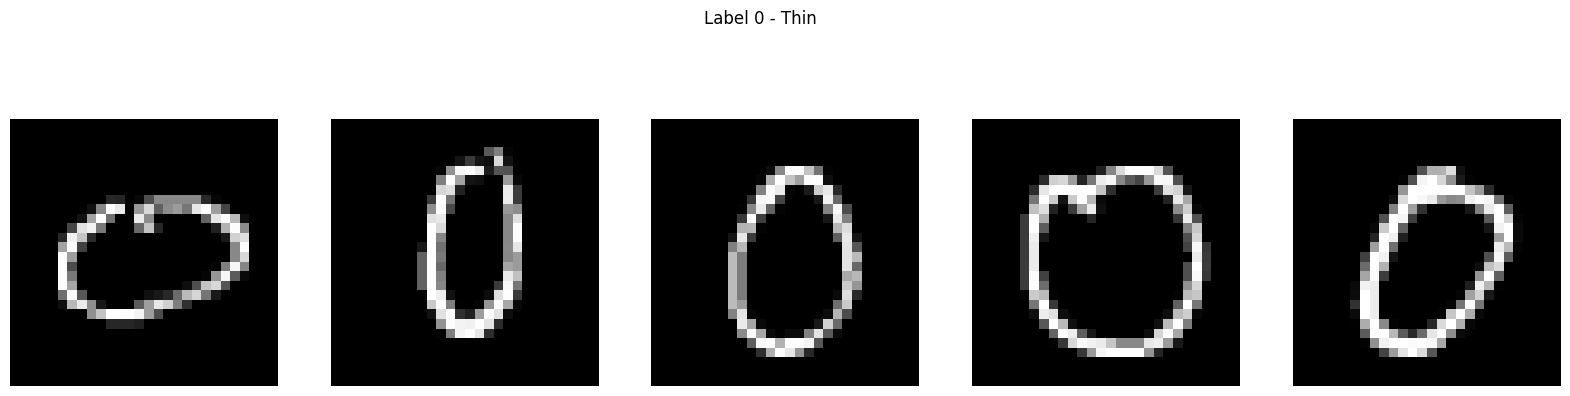

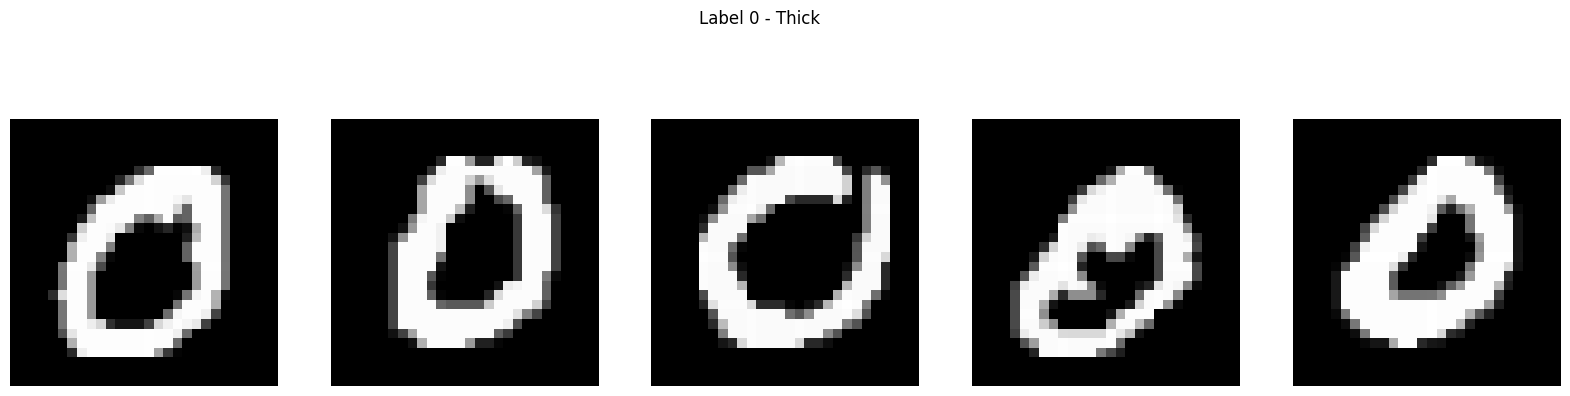

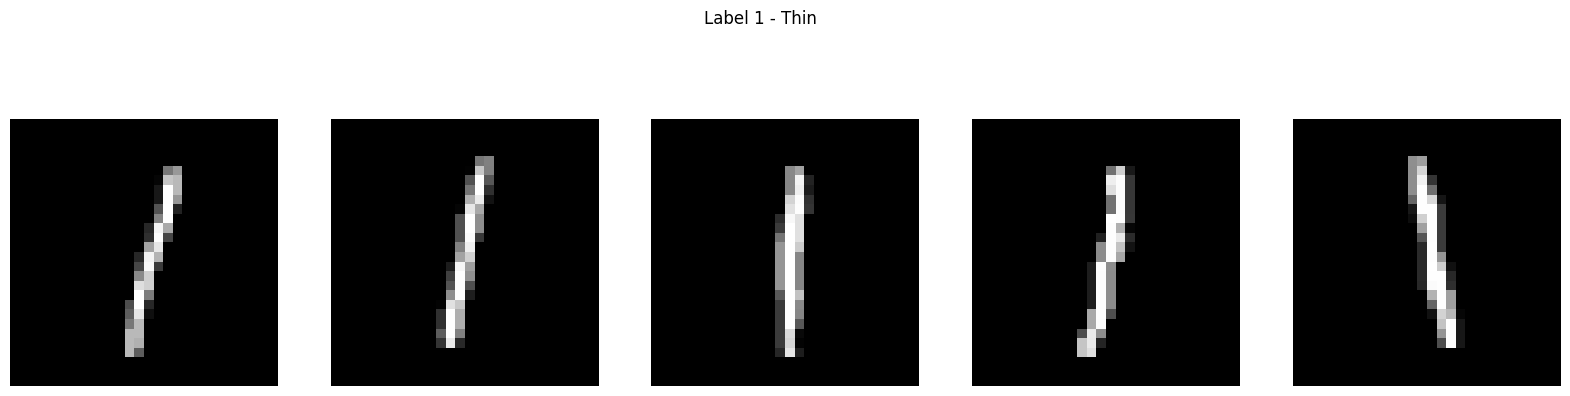

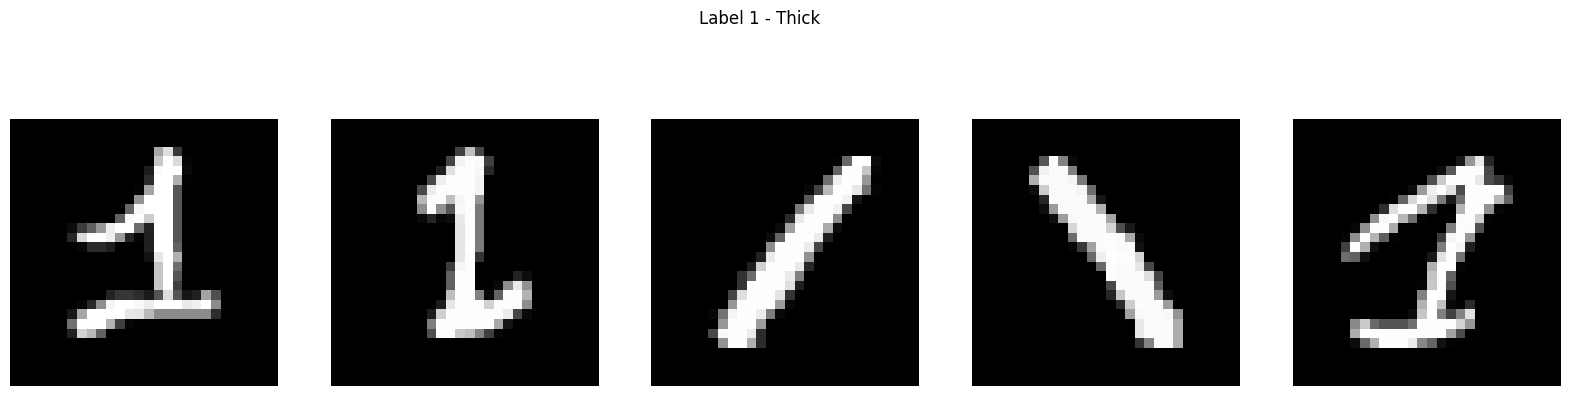

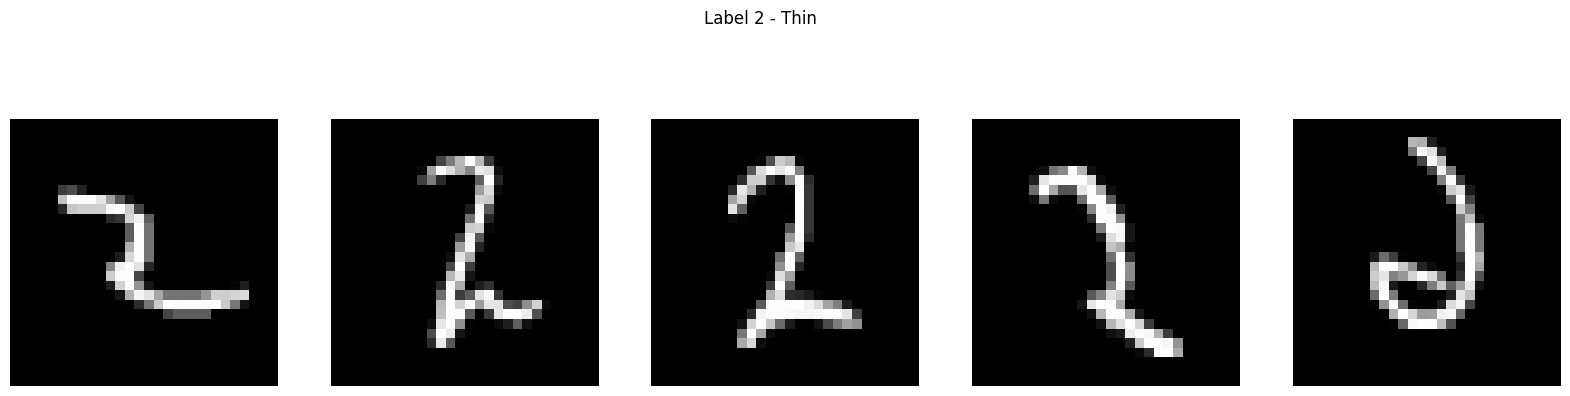

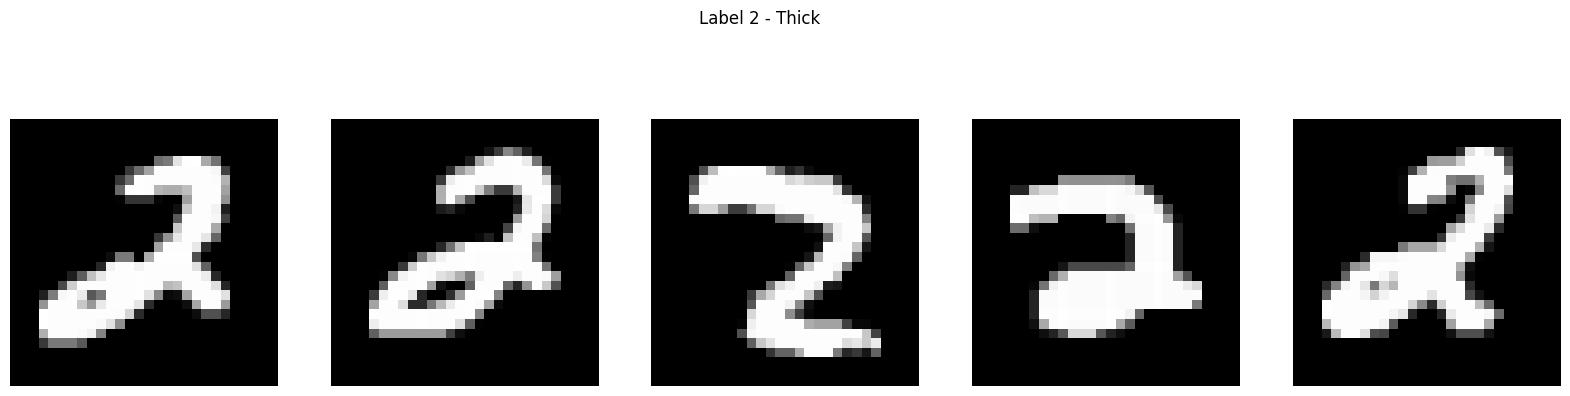

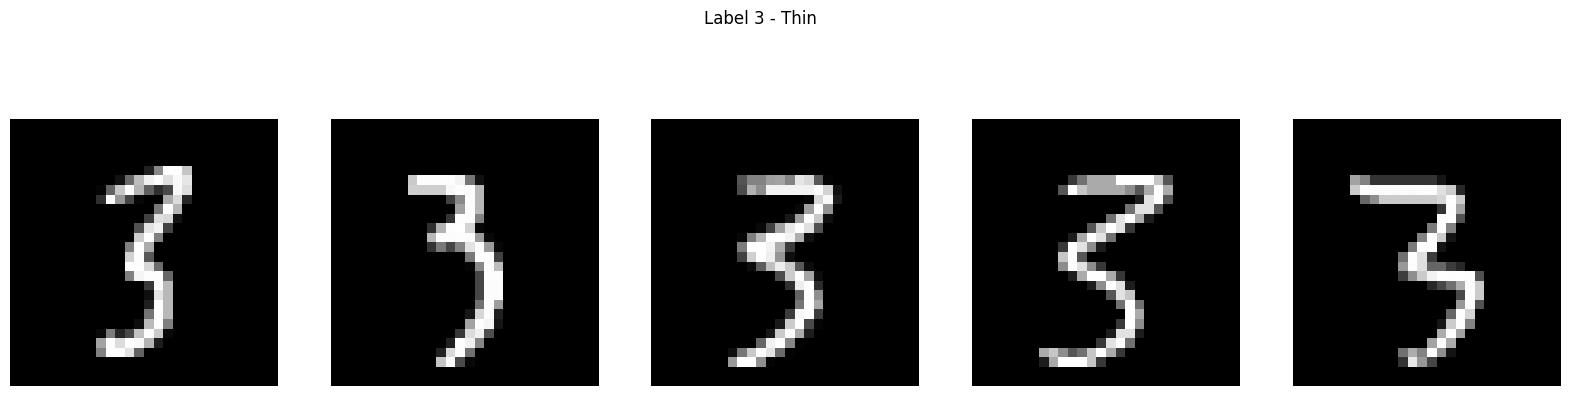

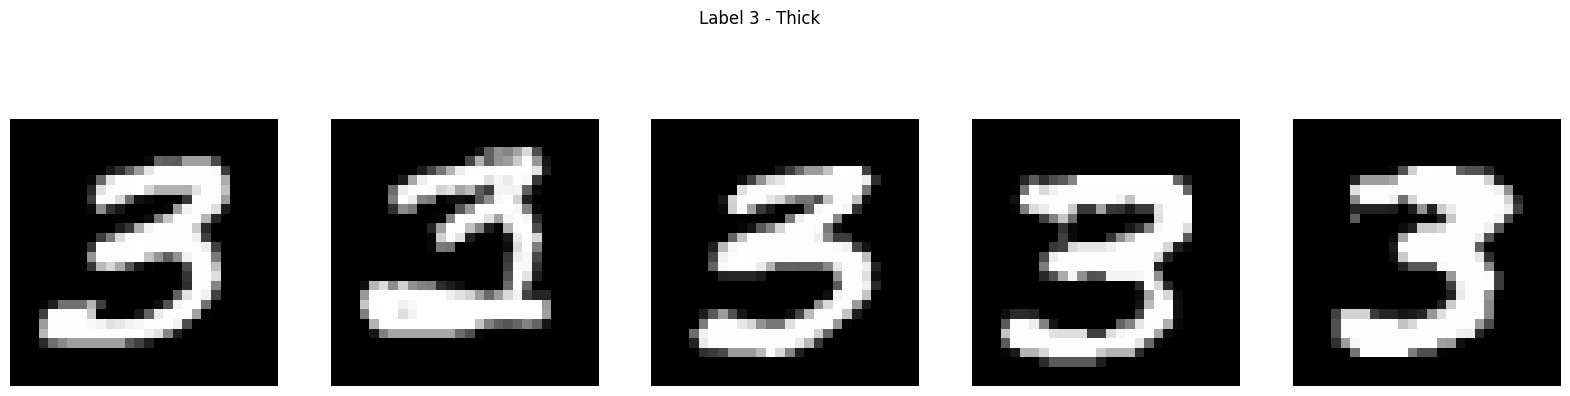

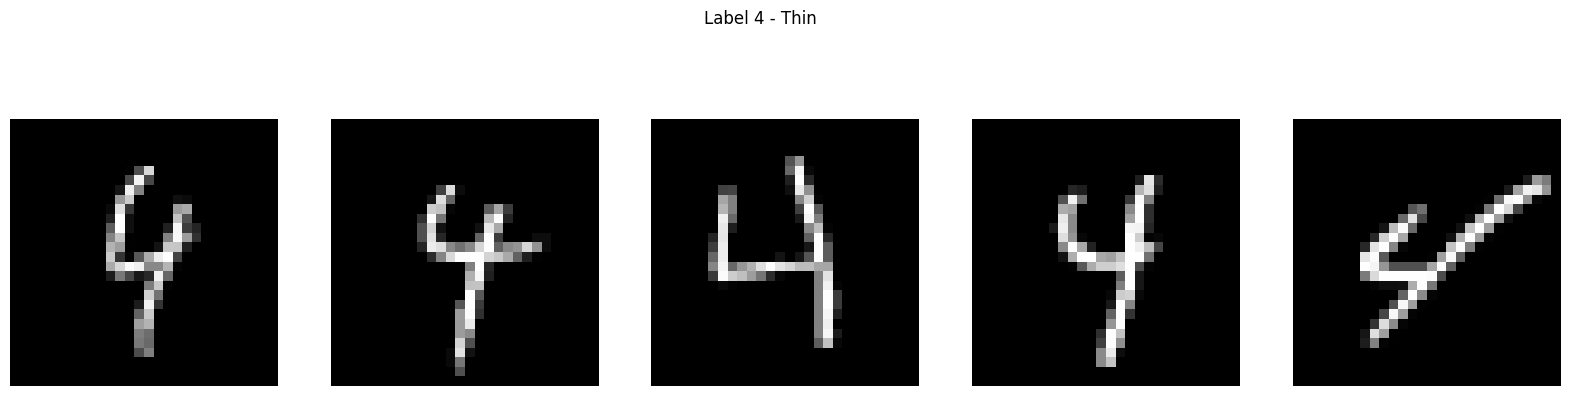

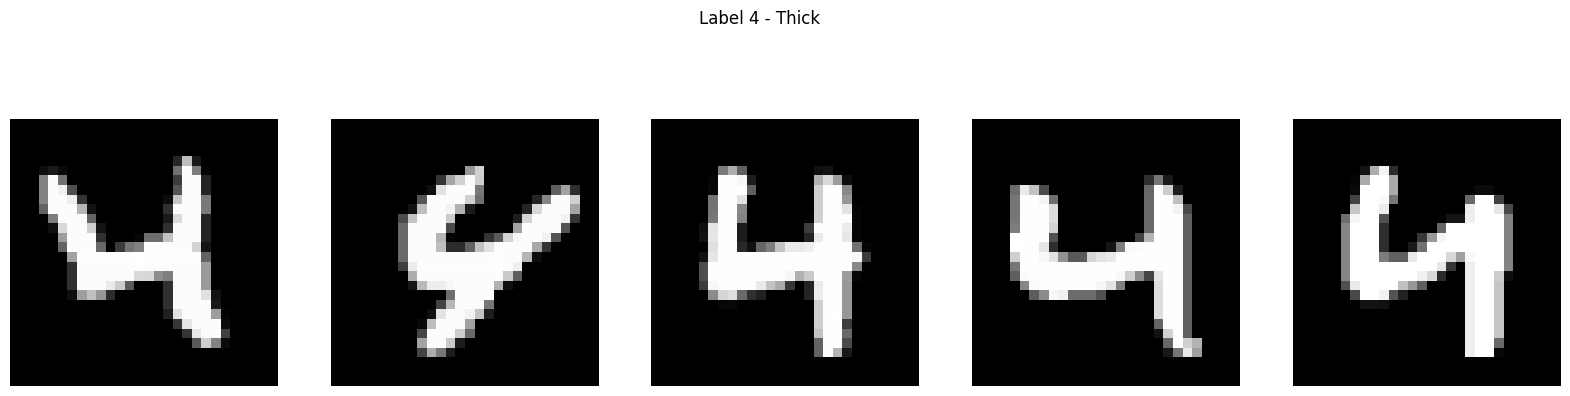

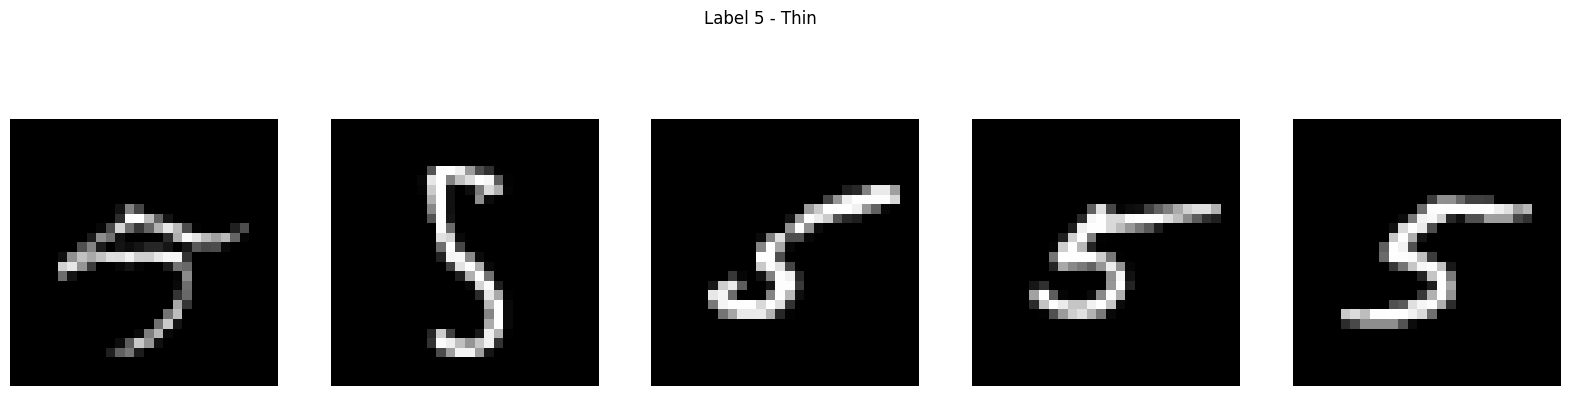

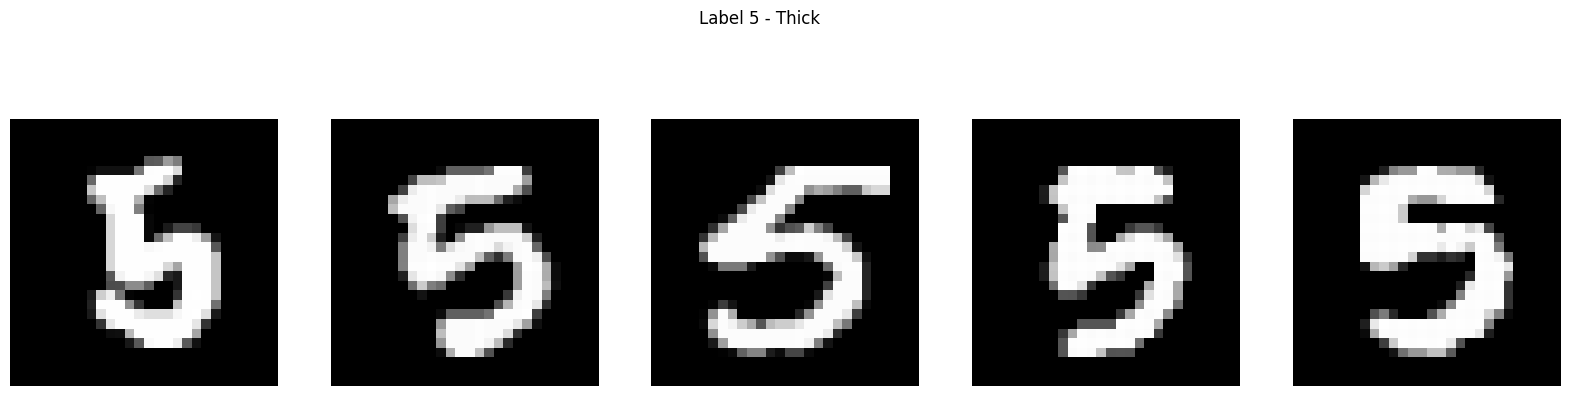

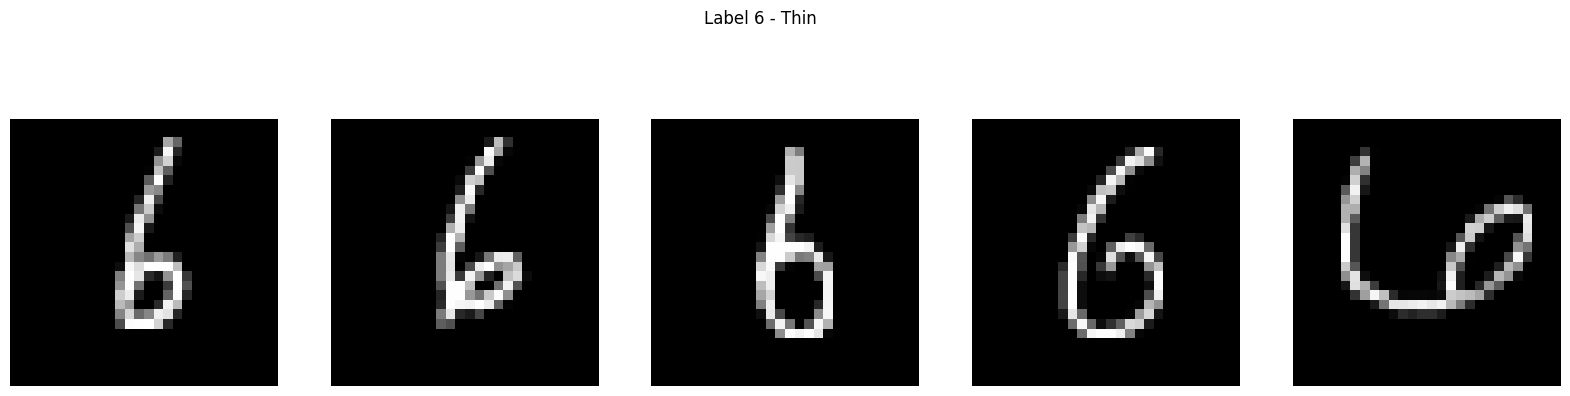

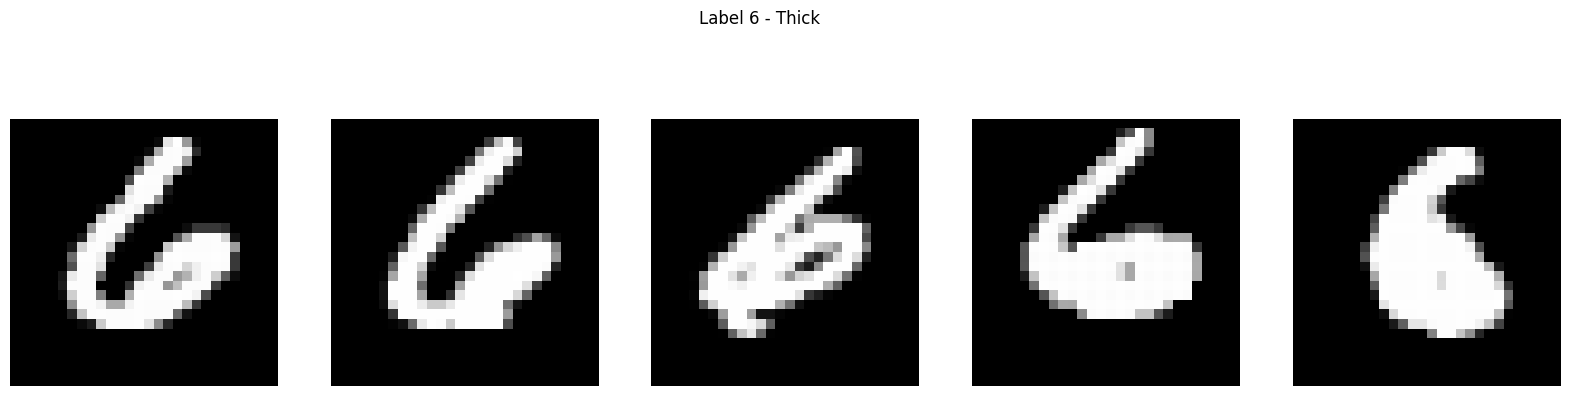

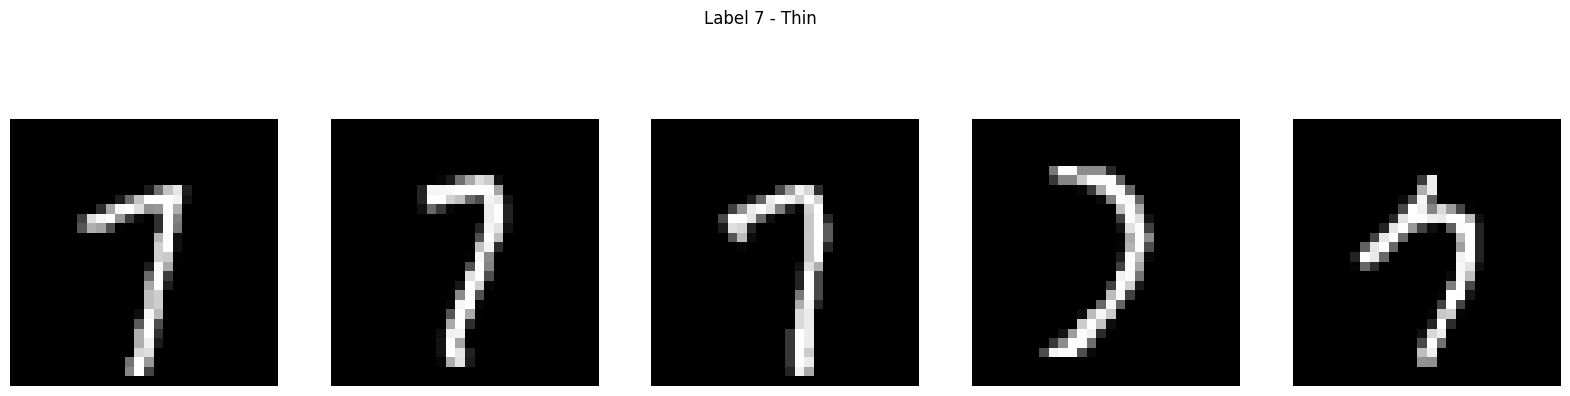

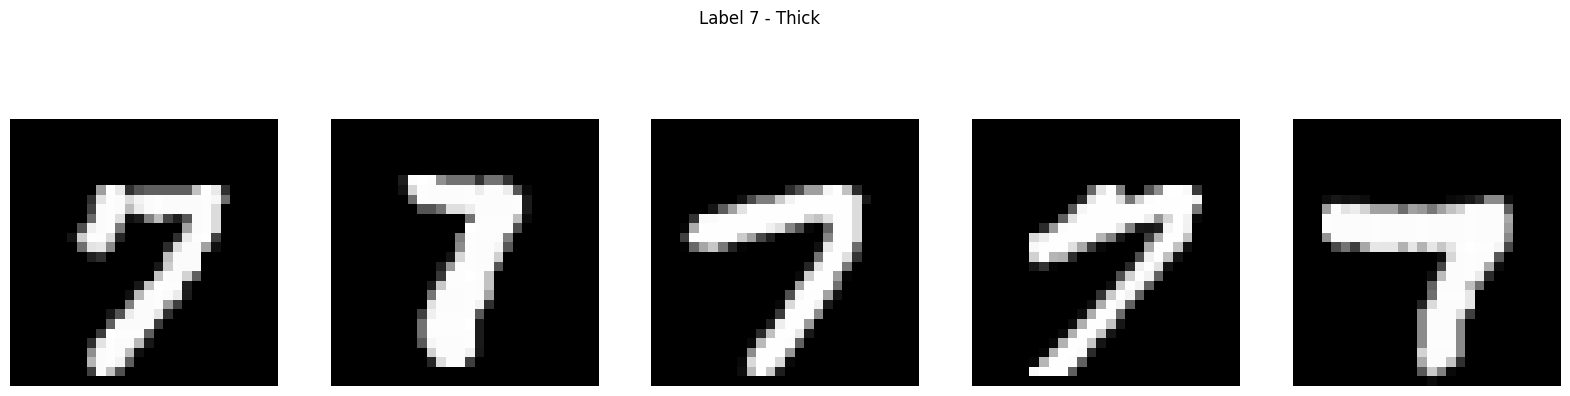

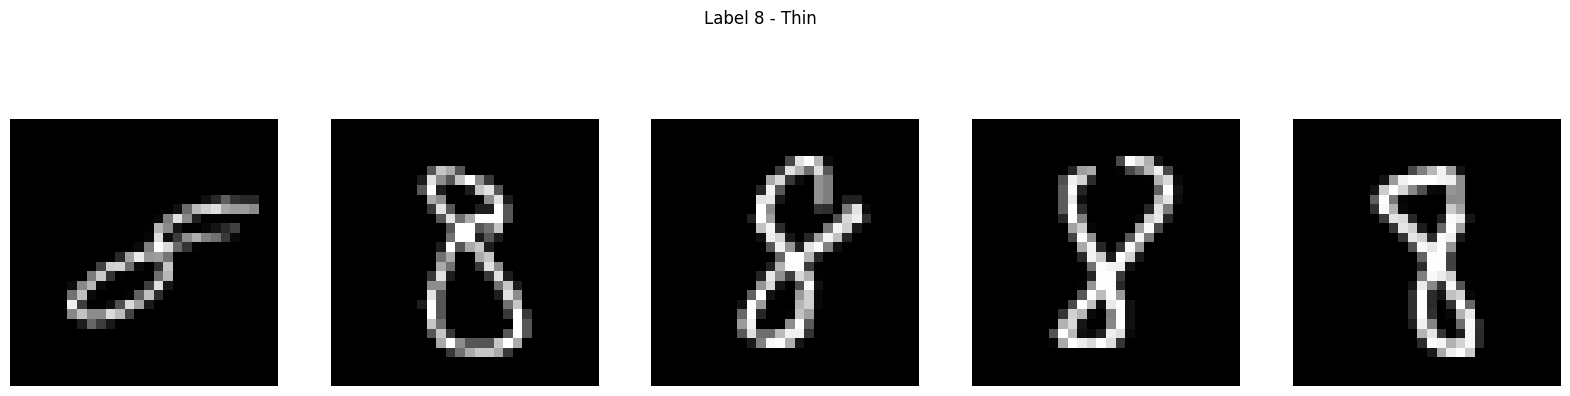

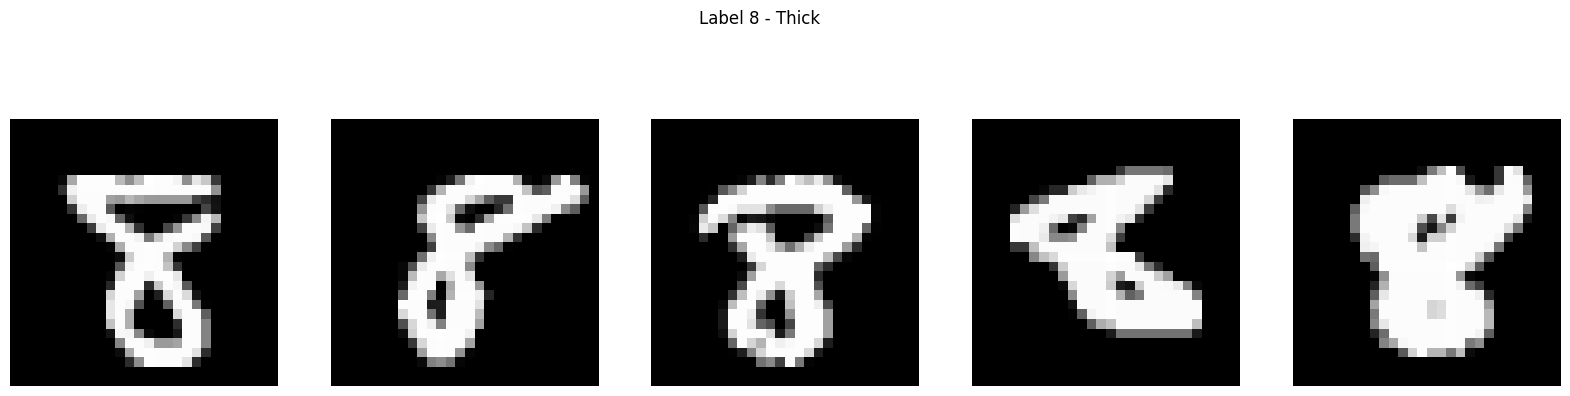

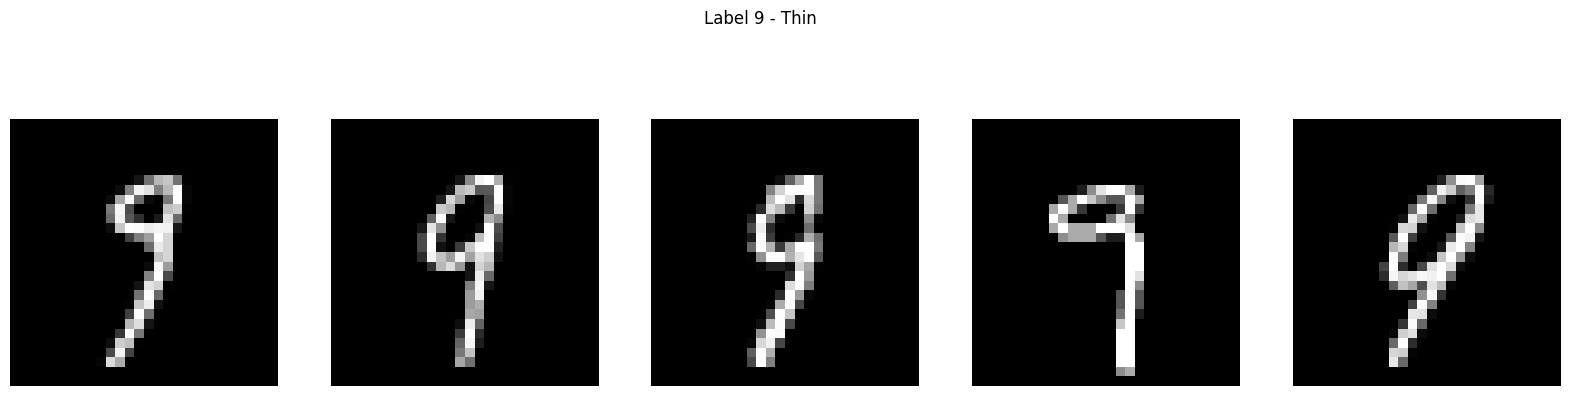

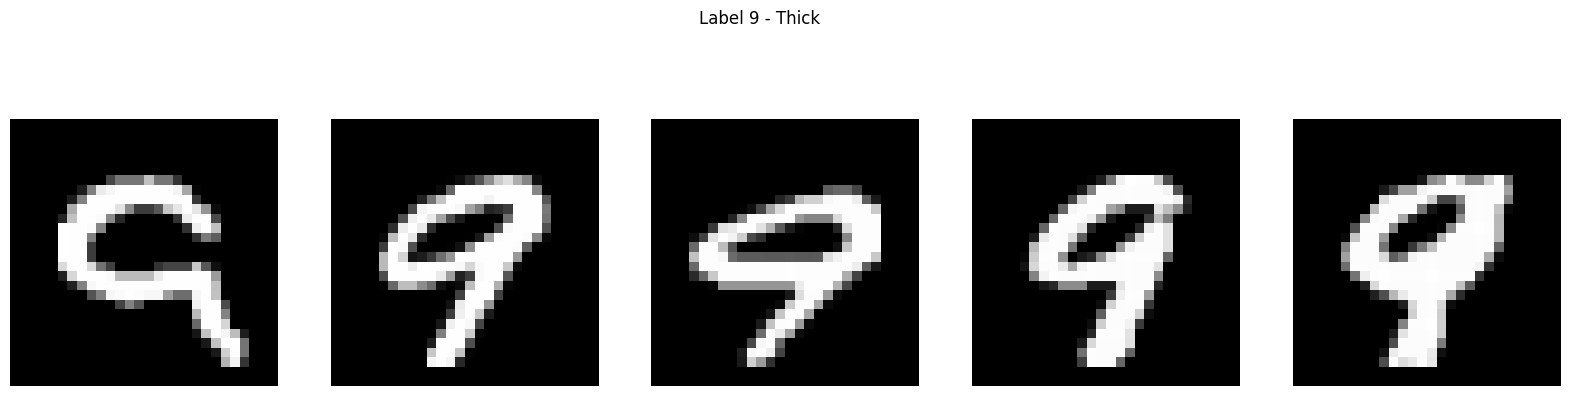

In [55]:
# Sample Images by Label
def sample_images_by_label(dataset, num_samples=1000):
    label_dict = {i: [] for i in range(10)}  # Labels 0-9
    for img, label in dataset:
        label_dict[label].append(img.numpy().squeeze())  # Remove channel dimension
    for label in label_dict:
        label_dict[label] = np.array(label_dict[label][:num_samples])
    return label_dict

# Compute Pixel Sums
def compute_pixel_sums(images):
    return images.reshape(images.shape[0], -1).sum(axis=1)  # Sum over all pixels

# Select Extremes
def select_extremes(images, pixel_sums, num_extremes=100):
    sorted_indices = np.argsort(pixel_sums)
    thin_indices = sorted_indices[:num_extremes]
    thick_indices = sorted_indices[-num_extremes:]
    return images[thin_indices], images[thick_indices]

# Generate Pair Dataset and Plot
def generate_thin_thick_images(dataset, num_samples=100, num_extremes=5):
    label_dict = sample_images_by_label(dataset, num_samples)
    thin_image = []
    thick_image = []
    for label, images in label_dict.items():
        pixel_sums = compute_pixel_sums(images)
        thin_images, thick_images = select_extremes(images, pixel_sums, num_extremes)

        thin_image.append(thin_images)
        thick_image.append(thick_images)
        # Plot Thin Images
        plt.figure(figsize=(num_extremes*4, 5))
        for i in range(num_extremes):
            plt.subplot(1, num_extremes, i + 1)
            plt.imshow(thin_images[i], cmap='gray')
            plt.axis('off')
        plt.suptitle(f"Label {label} - Thin")
        plt.show()

        # Plot Thick Images
        plt.figure(figsize=(num_extremes*4, 5))
        for i in range(num_extremes):
            plt.subplot(1, num_extremes, i + 1)
            plt.imshow(thick_images[i], cmap='gray')
            plt.axis('off')
        plt.suptitle(f"Label {label} - Thick")
        plt.show()

    thin_image  = [pair for sublist in thin_image for pair in sublist]
    thick_image = [pair for sublist in thick_image for pair in sublist]
    return  thin_image, thick_image

# Run the function
thin_images, thick_images = generate_thin_thick_images(dataset)

In [56]:
def identify_direction(generator, thick_samples, thin_samples, latent_dim, steps=200, device=device):

    generator.eval()  # Ensure generator is in evaluation mode

    thick_latents = []
    thin_latents = []

    # Process thick samples to get their latent vectors
    for sample in thick_samples:
        latent, _ = invert_to_latent_vector(generator, sample, latent_dim, device, num_steps=steps)
        thick_latents.append(latent)

    # Process thin samples to get their latent vectors
    for sample in thin_samples:
        latent, _ = invert_to_latent_vector(generator, sample, latent_dim, device, num_steps=steps)
        thin_latents.append(latent)

    # Stack latents into tensors for pairwise computation
    thick_latents = torch.stack(thick_latents)
    thin_latents = torch.stack(thin_latents)

    # Ensure both sets have the same number of samples
    num_pairs = min(len(thick_latents), len(thin_latents))
    thick_latents = thick_latents[:num_pairs]
    thin_latents = thin_latents[:num_pairs]

    # Compute pairwise differences and average them
    differences = thick_latents - thin_latents
    direction = torch.mean(differences, dim=0)

    return direction

def modify_attribute(generator, original_latent, direction, alpha, device):
    generator.eval()
    modified_latent = original_latent + alpha * direction
    modified_sample = generator(modified_latent)
    return modified_sample

def plot_modified_images(generator, dataloader, direction, latent_dim, alpha_values, device, num_samples=5, steps = 500):
    generator.eval()

    # Get samples from the dataloader
    samples, labels = next(iter(dataloader))
    samples = samples[:num_samples].to(device)

    # Invert images to latent space
    latents = [invert_to_latent_vector(generator, sample, latent_dim, device ,num_steps=steps )[0] for sample in samples]

    # Set up the plot
    fig, axes = plt.subplots(num_samples, len(alpha_values)+1, figsize=(5*(len(alpha_values)+1), 5 * num_samples))
    for i, (latent, original_image) in enumerate(zip(latents, samples)):
        # Prepare original image for plotting
        original_image = original_image.cpu().squeeze().numpy()

        # Plot the original image
        axes[i, 0].imshow(original_image, cmap="gray")
        axes[i, 0].set_title("Original")
        axes[i, 0].axis("off")

        for j, alpha in enumerate(alpha_values):
            # Modify the latent vector and generate a modified image
            modified_sample = modify_attribute(generator, latent, direction, alpha, device)
            modified_image = modified_sample.cpu().squeeze().detach().numpy()

            # Plot the modified image
            axes[i, j + 1].imshow(modified_image, cmap="gray")
            axes[i, j + 1].set_title(f"Alpha {alpha}")
            axes[i, j + 1].axis("off")

    plt.tight_layout()
    plt.show()

In [57]:
# Calculate direction vector
direction = identify_direction(generator, thick_images, thin_images, latent_dim, device=device, steps=500)

<ipython-input-23-7ce7a7900f9e>:25: UserWarning: Using a target size (torch.Size([28, 28])) that is different to the input size (torch.Size([1, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(generated_image_resized, real_image)


Step [0/500], Loss: 0.8222165703773499
Step [100/500], Loss: 0.20605596899986267
Step [200/500], Loss: 0.16880343854427338
Step [300/500], Loss: 0.1476261019706726
Step [400/500], Loss: 0.13683949410915375
Step [0/500], Loss: 0.36585521697998047
Step [100/500], Loss: 0.1641114205121994
Step [200/500], Loss: 0.13742849230766296
Step [300/500], Loss: 0.12260748445987701
Step [400/500], Loss: 0.11867699772119522
Step [0/500], Loss: 0.900326132774353
Step [100/500], Loss: 0.318763792514801
Step [200/500], Loss: 0.2519654929637909
Step [300/500], Loss: 0.23758520185947418
Step [400/500], Loss: 0.22989973425865173
Step [0/500], Loss: 0.8290104866027832
Step [100/500], Loss: 0.5499913096427917
Step [200/500], Loss: 0.1733596920967102
Step [300/500], Loss: 0.15254993736743927
Step [400/500], Loss: 0.12748342752456665
Step [0/500], Loss: 0.8714893460273743
Step [100/500], Loss: 0.3010196089744568
Step [200/500], Loss: 0.1097935363650322
Step [300/500], Loss: 0.10344300419092178
Step [400/500], 

<ipython-input-23-7ce7a7900f9e>:25: UserWarning: Using a target size (torch.Size([1, 28, 28])) that is different to the input size (torch.Size([1, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(generated_image_resized, real_image)


Step [0/500], Loss: 0.5751917362213135
Step [100/500], Loss: 0.1321677714586258
Step [200/500], Loss: 0.11240778118371964
Step [300/500], Loss: 0.10476043820381165
Step [400/500], Loss: 0.09553684294223785
Step [0/500], Loss: 0.5710106492042542
Step [100/500], Loss: 0.29843276739120483
Step [200/500], Loss: 0.24433289468288422
Step [300/500], Loss: 0.1353767365217209
Step [400/500], Loss: 0.12916885316371918
Step [0/500], Loss: 0.5843595266342163
Step [100/500], Loss: 0.10825692117214203
Step [200/500], Loss: 0.09715673327445984
Step [300/500], Loss: 0.08903805166482925
Step [400/500], Loss: 0.0878872349858284
Step [0/500], Loss: 0.48346957564353943
Step [100/500], Loss: 0.29633501172065735
Step [200/500], Loss: 0.10557103157043457
Step [300/500], Loss: 0.10067571699619293
Step [400/500], Loss: 0.09387185424566269
Step [0/500], Loss: 0.4015827476978302
Step [100/500], Loss: 0.0989801213145256
Step [200/500], Loss: 0.08761261403560638
Step [300/500], Loss: 0.08475428819656372
Step [400/

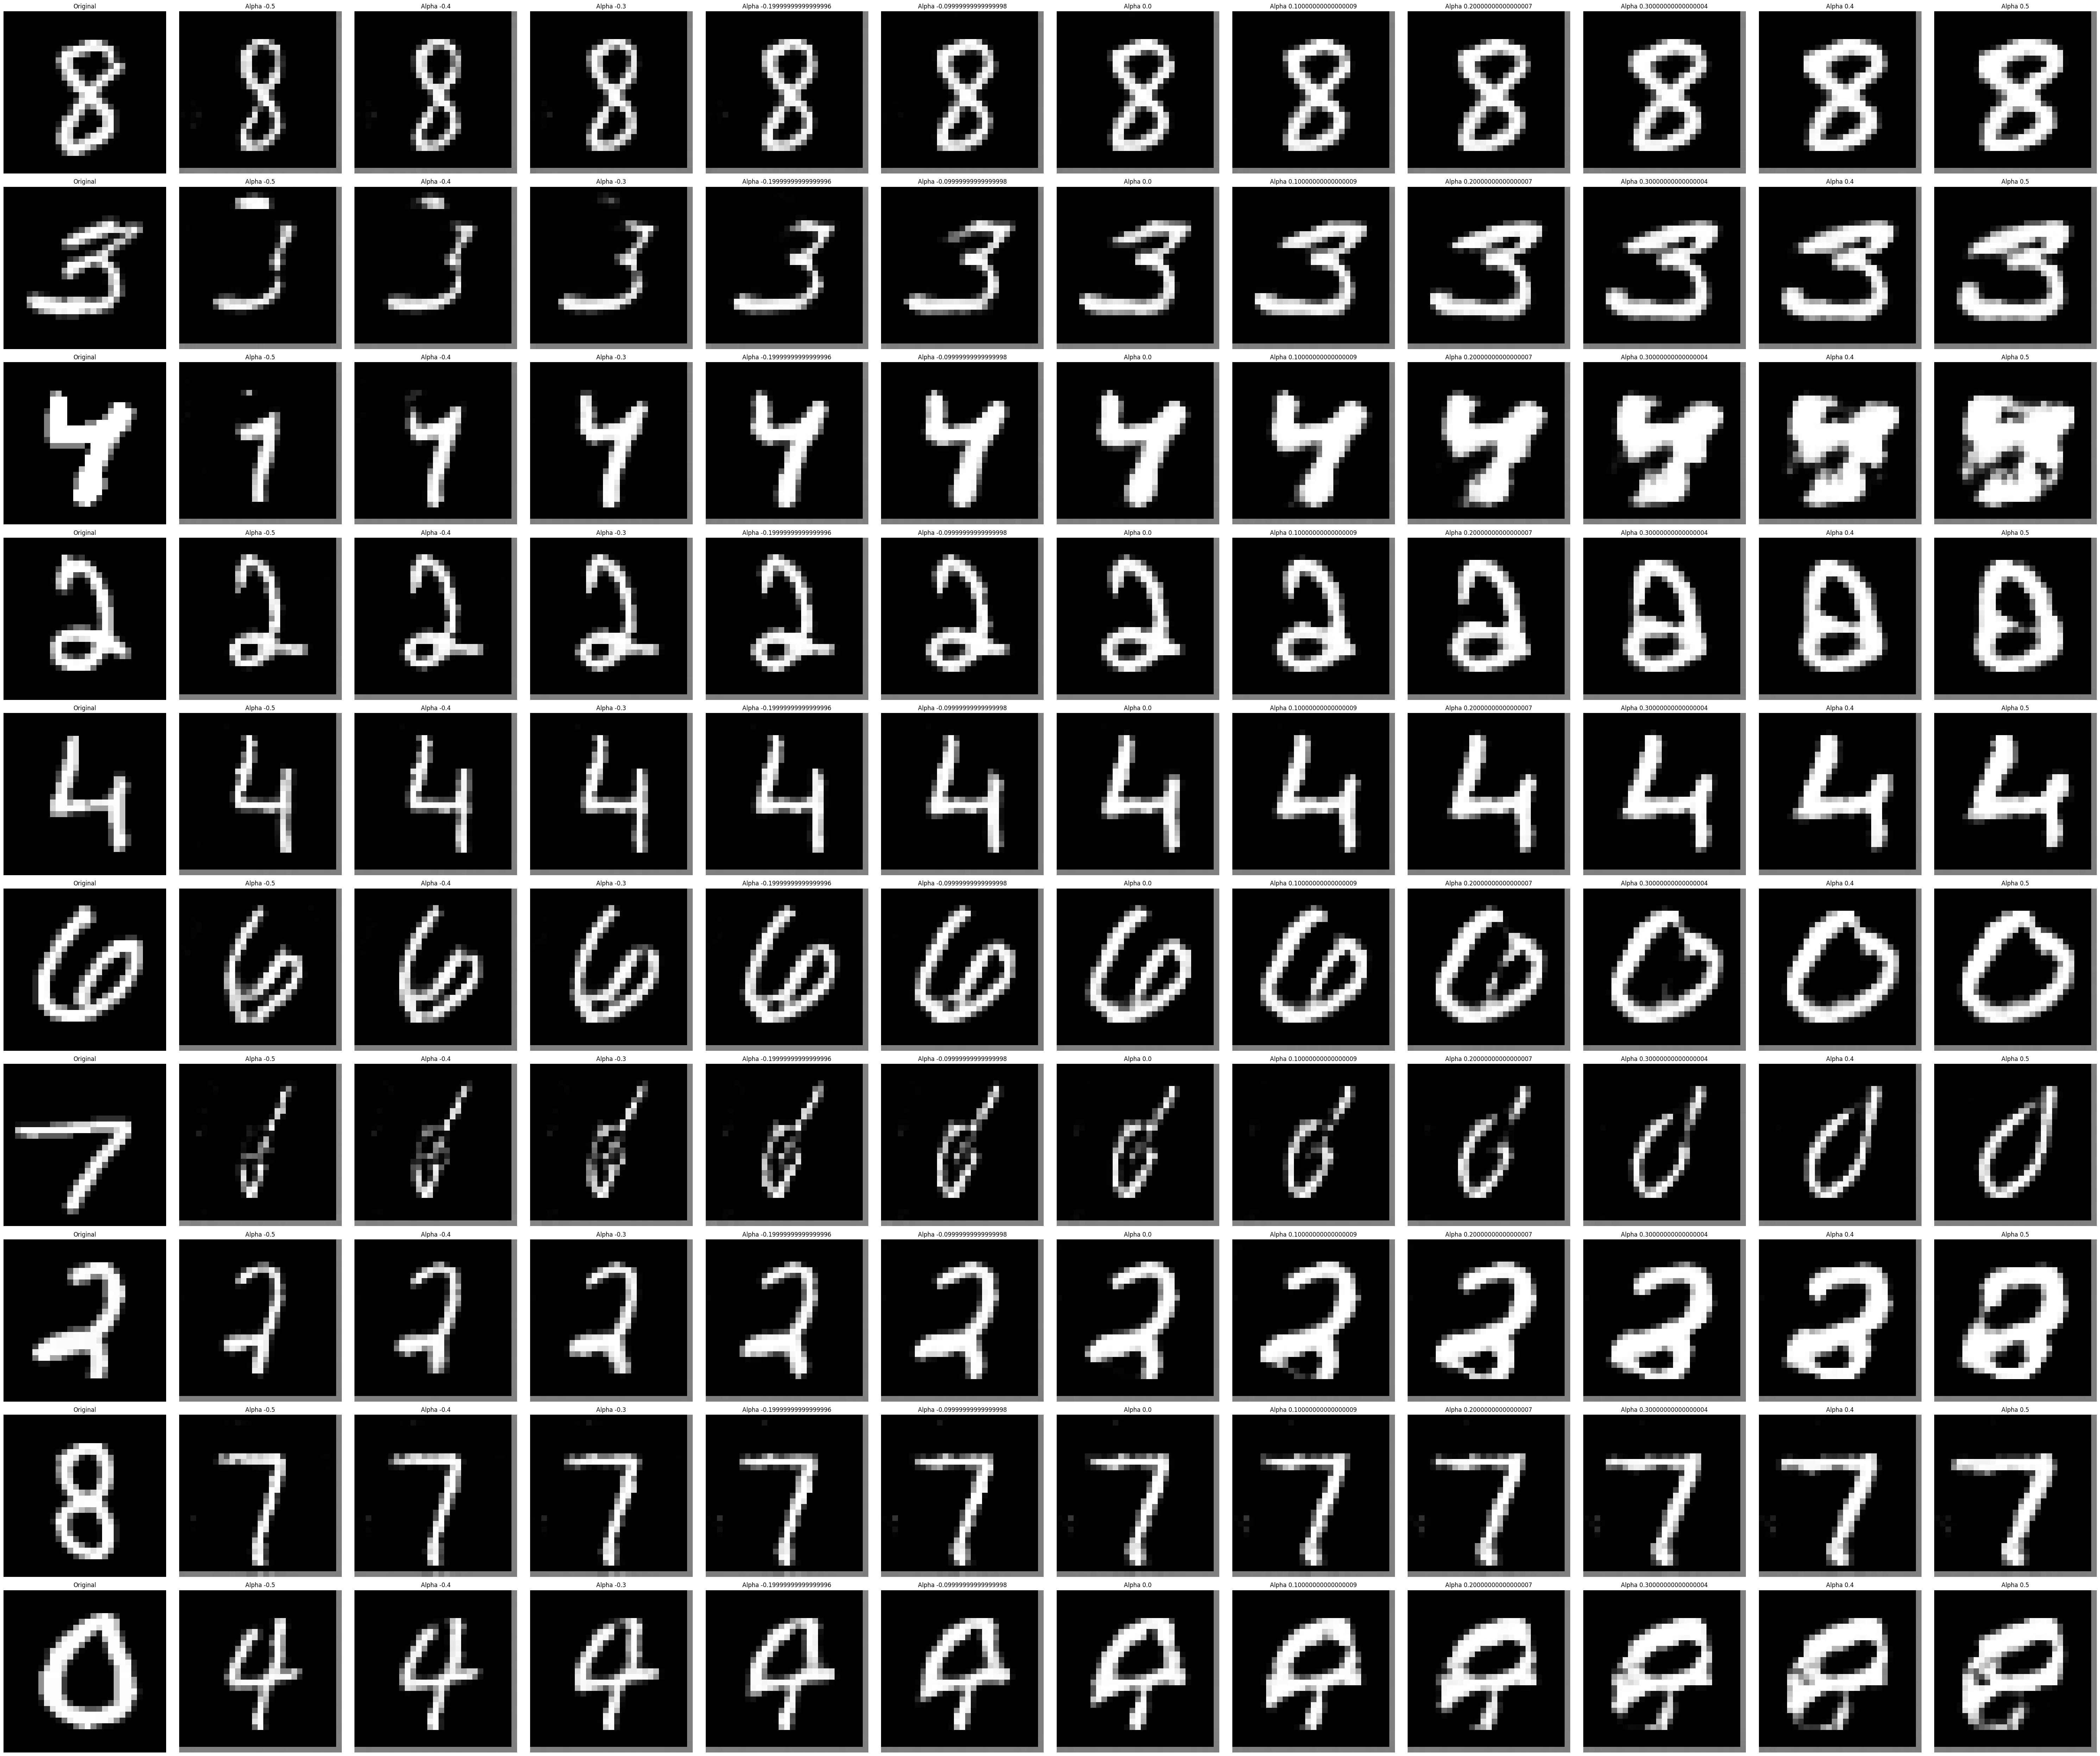

In [68]:
# Modify and visualize images
alpha_values = np.linspace(-0.5,0.5,11)
plot_modified_images(generator, train_loader, direction, latent_dim, alpha_values, device=device, num_samples=10, steps = 500)

#### Changin digits


**1. Computing Class Latent Averages**

Function: `compute_class_latents`

This function computes the **average latent vector** for each class in the dataset. A latent vector represents the encoded information used by the generator to create an image. Here's how it works:

1. **Initialize Storage for Each Class**:
   - A dictionary `class_latents` is created, where each key (0-9) corresponds to a class label, and the value is a list to store latent vectors.

2. **Sample Images by Class**:
   - For each image in the dataset:
     - The class label is checked.
     - The image is passed through the **GAN inversion process** (`invert_to_latent_vector`) to find its latent vector.
     - The latent vector is stored in the dictionary until the required number of samples (`num_samples`) is reached for that class.

3. **Compute Averages**:
   - For each class, the latent vectors are averaged to get a single **average latent vector** that represents the entire class.

This results in a dictionary, `class_avg_latents`, where each class label maps to its average latent vector.

---

**2. Calculating Transformation Directions**

Function: `calculate_class_directions`

This function calculates **directions** in the latent space for transforming one class into another. Specifically:

1. **Identify the Target Class**:
   - Select the average latent vector of the target class (`target_class`) from `class_avg_latents`.

2. **Calculate Directions**:
   - For each source class in `source_classes`, compute the vector difference between the source class's average latent vector and the target class's average latent vector:
     - Direction = Target Latent - Source Latent

3. **Store Directions**:
   - The directions for all source classes are stored in a dictionary, `directions`.

These directions describe how to move in the latent space to transform samples from a source class into the target class.

---

**3. Applying the Mean Direction**

Function:`plot_transformations_with_mean_direction`

This function applies a **mean transformation direction** to a batch of samples and visualizes the results.

1. **Calculate Mean Direction**:
   - Averages all directions from `directions` to compute a single **mean direction**:
     - Mean Direction = Average of All Directions

2. **Map Samples to Latent Space**:
   - Each input sample is inverted into its latent vector using the GAN inversion function.

3. **Apply Transformations**:
   - The mean direction is applied to each latent vector with scaling factors (`alphas`) to control the intensity of the transformation:
     - Modified Latent = Original Latent +  alpha *  Mean Direction

4. **Generate and Plot Images**:
   - For each sample:
     - The original image is plotted.
     - Transformed images corresponding to different alpha values are generated and displayed.

This function visualizes how the mean direction transforms input samples along the specified latent space axis.



In [72]:
def compute_class_latents(generator, dataset, latent_dim, device, num_samples=100, steps=200):
    class_latents = {i: [] for i in range(10)}

    # Sample images by class
    for img, label in dataset:
        if len(class_latents[label]) < num_samples:
            latent, _ = invert_to_latent_vector(generator, img.unsqueeze(0), latent_dim, device, num_steps=steps)
            class_latents[label].append(latent)

    # Compute the average latent vector for each class
    class_avg_latents = {
        label: torch.mean(torch.stack(latents), dim=0)
        for label, latents in class_latents.items()
    }

    return class_avg_latents

def calculate_class_directions(class_avg_latents, source_classes, target_class):
    directions = {}
    target_latent = class_avg_latents[target_class]
    for source_class in source_classes:
        source_latent = class_avg_latents[source_class]
        directions[source_class] = target_latent - source_latent
    return directions

def plot_transformations_with_mean_direction(generator, samples, latent_dim, directions, alphas, device):
    generator.eval()

    # Compute the mean direction
    mean_direction = torch.mean(torch.stack(list(directions.values())), dim=0)

    # Invert samples to latent space
    latents = [invert_to_latent_vector(generator, sample.unsqueeze(0), latent_dim, device)[0] for sample in samples]

    num_samples = len(samples)
    fig, axes = plt.subplots(num_samples, len(alphas) + 1, figsize=(5 * (len(alphas) + 1), 3 * num_samples))

    for i, (latent, original_image) in enumerate(zip(latents, samples)):
        original_image = original_image.squeeze().cpu().numpy()

        # Plot the original image
        axes[i, 0].imshow(original_image, cmap="gray")
        axes[i, 0].set_title("Original")
        axes[i, 0].axis("off")

        for j, alpha in enumerate(alphas):
            # Modify the latent vector using the mean direction
            modified_latent = latent + alpha * mean_direction
            modified_image = generator(modified_latent).squeeze().cpu().detach().numpy()

            # Plot the modified image
            axes[i, j + 1].imshow(modified_image, cmap="gray")
            axes[i, j + 1].set_title(f"Alpha {alpha}")
            axes[i, j + 1].axis("off")

    plt.tight_layout()
    plt.show()


In [63]:
# Compute average latent vectors for each class
class_avg_latents = compute_class_latents(generator, dataset, latent_dim, device, num_samples=10, steps=200)

# Define source classes and target class
source_classes = [0, 1, 2, 4, 5, 6, 7, 8, 9]  # Example source classes
target_class = 3  # Target class

# Calculate directions for each source class to the target class
directions = calculate_class_directions(class_avg_latents, source_classes, target_class)

Step [0/200], Loss: 0.502022922039032
Step [100/200], Loss: 0.3978843092918396
Step [0/200], Loss: 0.6106309294700623
Step [100/200], Loss: 0.48257508873939514
Step [0/200], Loss: 0.7239943146705627
Step [100/200], Loss: 0.3374987244606018
Step [0/200], Loss: 0.3187026083469391
Step [100/200], Loss: 0.11448311060667038
Step [0/200], Loss: 0.45478999614715576
Step [100/200], Loss: 0.33201777935028076
Step [0/200], Loss: 0.5243987441062927
Step [100/200], Loss: 0.2729485034942627
Step [0/200], Loss: 0.30181995034217834
Step [100/200], Loss: 0.09370633959770203
Step [0/200], Loss: 0.5083457827568054
Step [100/200], Loss: 0.11685137450695038
Step [0/200], Loss: 0.6209828853607178
Step [100/200], Loss: 0.10742589086294174
Step [0/200], Loss: 0.6104245781898499
Step [100/200], Loss: 0.34093615412712097
Step [0/200], Loss: 0.37867915630340576
Step [100/200], Loss: 0.11529634892940521
Step [0/200], Loss: 0.41464367508888245
Step [100/200], Loss: 0.2682368755340576
Step [0/200], Loss: 0.7506541

Step [0/200], Loss: 0.3194045424461365
Step [100/200], Loss: 0.2372492104768753
Step [0/200], Loss: 0.3156099021434784
Step [100/200], Loss: 0.14332179725170135
Step [0/200], Loss: 0.4453936815261841
Step [100/200], Loss: 0.089859239757061
Step [0/200], Loss: 0.4616904556751251
Step [100/200], Loss: 0.11553357541561127
Step [0/200], Loss: 0.5703738927841187
Step [100/200], Loss: 0.2553834319114685
Step [0/200], Loss: 0.8115789890289307
Step [100/200], Loss: 0.12536358833312988
Step [0/200], Loss: 0.1542958766222
Step [100/200], Loss: 0.07672563940286636
Step [0/200], Loss: 0.48989784717559814
Step [100/200], Loss: 0.2189972847700119
Step [0/200], Loss: 0.24518798291683197
Step [100/200], Loss: 0.08802952617406845
Step [0/200], Loss: 0.5223818421363831
Step [100/200], Loss: 0.11499927937984467


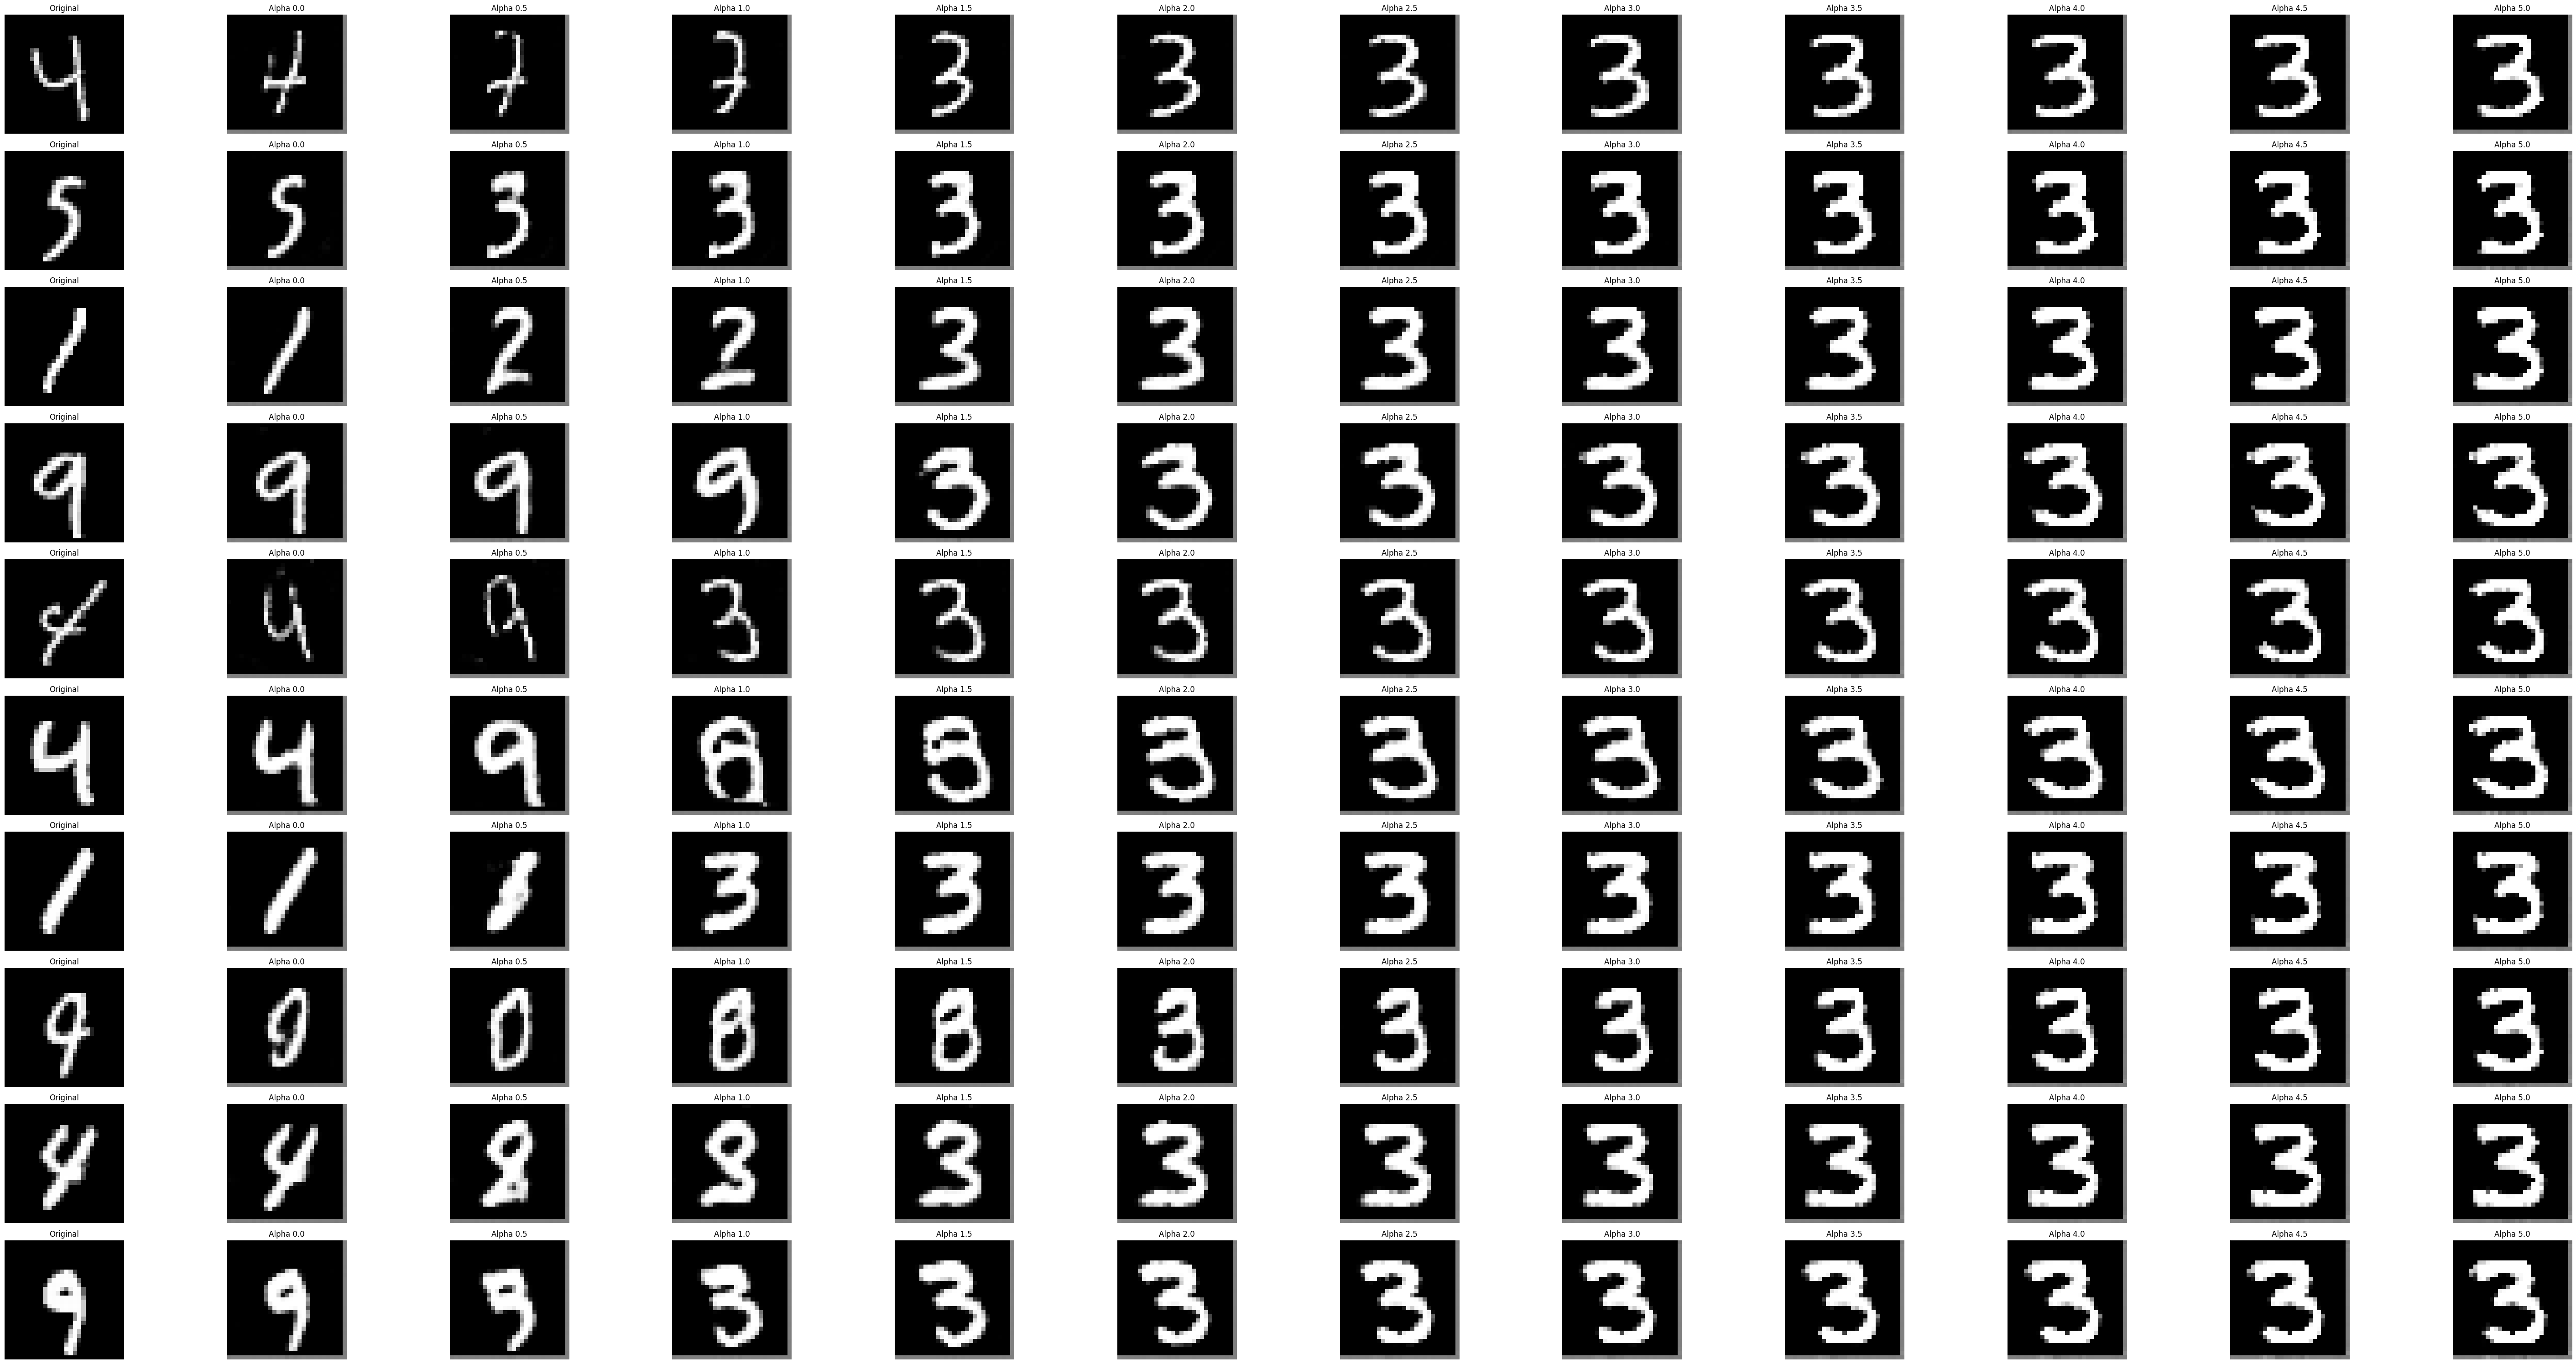

In [73]:
# Get a batch of samples
samples, _ = next(iter(train_loader))
samples = samples[:10].to(device)  # Take 5 samples for visualization
alphas = np.linspace(0, 5, 11)  # Alphas for transformation

# Plot transformations using the mean direction
plot_transformations_with_mean_direction(generator, samples, latent_dim, directions, alphas, device)